In [95]:

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import re
from config import *
from clustering_utils import *

# Sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from kneed import KneeLocator
from scipy import stats
from sklearn.metrics import accuracy_score
from scipy.cluster.hierarchy import dendrogram

import umap

# Visual
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from itertools import permutations 
from tqdm import tqdm
np.random.seed(42)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", palette='tab10', rc=custom_params)
plt.rcParams['figure.dpi'] = 300


SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Load data

In [96]:
all_features_with_info_raw = (pd.read_parquet(FEATURES_DIR / "all_features.pq"))
all_features_with_info_raw = all_features_with_info_raw[~(all_features_with_info_raw.isna().sum(axis=1) == all_features_with_info_raw.shape[1]-2)]


y_raw = pd.DataFrame(all_features_with_info_raw["y"], columns=["y"])


all_features_with_info = (all_features_with_info_raw)
 
X_initially_selected_features = (all_features_with_info
 .drop(["participant_id", "y"], axis=1)
 .pipe(remove_low_variance_features)
 .pipe(remove_multicollineraity, y_raw)
 .pipe(remove_outliers, "MAD", 10.0)
 .columns
 .to_list()
)

X = (all_features_with_info
     .query("y==1")
     [X_initially_selected_features]
     .dropna()
)

std_scaler = StandardScaler().fit(X.values)

X_stdz = pd.DataFrame(std_scaler.transform(X.values), columns=X.columns)

X_train, X_test,_ , _ = train_test_split(X_stdz, X_stdz.index, test_size=0.2, random_state=7) # ignore the X_stdz.index, we only want the X data



X_controls = (all_features_with_info
     .query("y==0")
     [X_initially_selected_features]
     .dropna()
)
X_controls_stdz = pd.DataFrame(std_scaler.transform(X_controls.values), columns=X_controls.columns)



/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_variance_threshold.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
2025-05-14 16:37:02,076 - INFO - clustering_utils.remove_low_variance_features:50 - Kept 463 features out of 518
2025-05-14 16:37:02,163 - INFO - clustering_utils.remove_multicollineraity:108 - Removed 164 highly correlated features: {'SMOOTH_PURSUITS_fixations_per_second_std', 'EVIL_BASTARD_amplitude_mean_sacc', 'FIXATIONS_avg_pupil_size_max_fix', 'REACTION_n_correct_trials', 'EVIL_BASTARD_fixation_distance_std', 'SHAPES_avg_pupil_size_median_fix', 'ANTI_SACCADE_avg_pupil_size_min_fix', 'SMOOTH_PURSUITS_duration_mean_fix', 'SMOOTH_PURSUITS_x_fixation_dist_std', 'SHAPES_avg_pupil_size_max_fix', 'KING_DEVICK_avg_pupil_size_mean_fix', 'SMOOTH_PURSUITS_fixations_per_second_max', 'EVIL_BASTARD_distance_to_fixpoint_mean', 'K

# Plot dendrogram

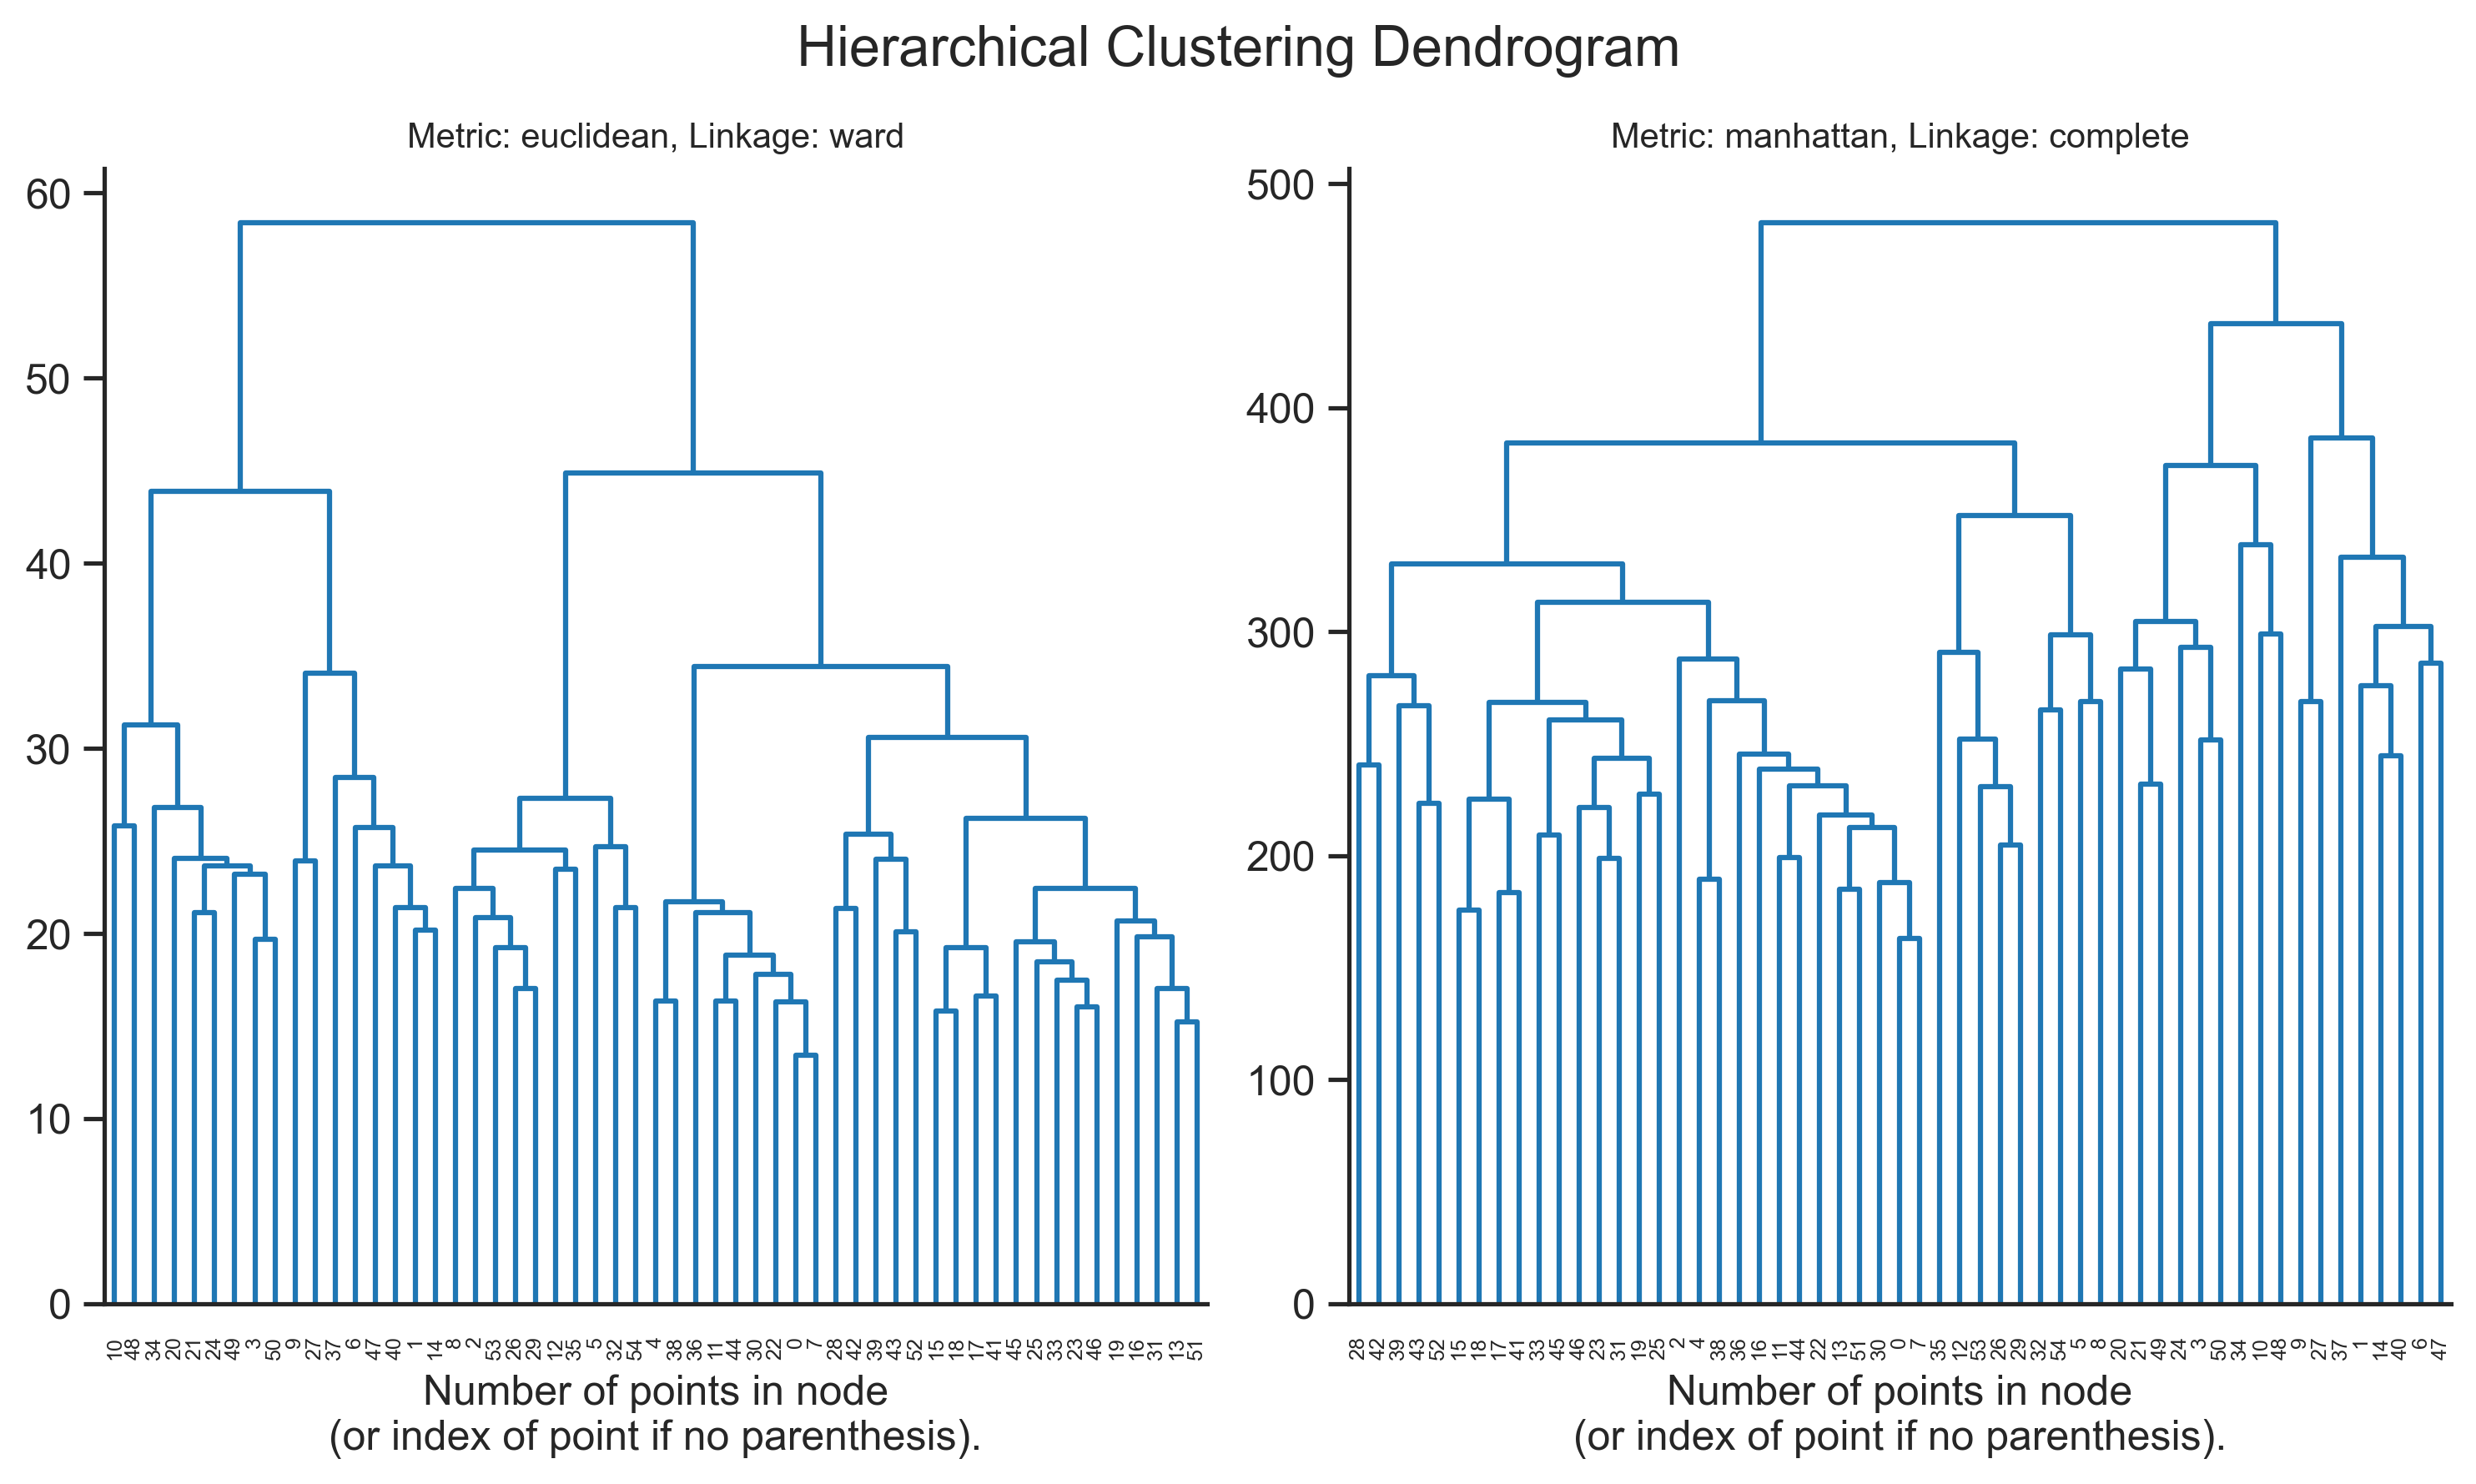

In [97]:



def plot_dendrogram(model, **kwargs):
    "Taken from the sklearn documentation"
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# Plot euclidean + ward


metric = 'euclidean'
linkage = 'ward'
fig, ax = plt.subplots(ncols=2, figsize=(10,6))

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,  linkage=linkage, metric=metric)

model = model.fit(X_stdz)
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode = 'level', p=100, color_threshold=0,ax= ax[0])

ax[0].set_xlabel("Number of points in node\n(or index of point if no parenthesis).")
ax[0].set_title(f"Metric: {metric}, Linkage: {linkage}")

# Plot manhattan + complete

metric = 'manhattan'
linkage = 'complete'

model = AgglomerativeClustering(distance_threshold=0,n_clusters=None,  linkage=linkage, metric=metric)

model = model.fit(X_stdz)
plt.suptitle("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode = 'level', p=100, color_threshold=0,ax= ax[1])
ax[1].set_xlabel("Number of points in node\n(or index of point if no parenthesis).")
ax[1].set_title(f"Metric: {metric}, Linkage: {linkage}")
plt.tight_layout()
plt.show()



From the dendrograms alone, a choice of 2 or 4 clusters would be ideal for euclidean + ward. For manhattan + complete, a choice of 2 or 3 clusters would be ideal. 

In [98]:

def perform_clustering(n_cluster, X, clustering_model, model_args) -> pd.DataFrame:
    """Performs clustering to get the initial values for all features

    Args:
        n_cluster (int): The number of clusters
        X (pd.DataFrame): DataFrame with all features
        model (sklearn model): The sklearn clustering model to be used. Supports AgglomerativeClustering and GaussianMixture
        linkage (str): 'ward', 'complete', 'single', 'average'
        metric (str): 'euclidean', 'manhattan'

    Returns:
        pd.DataFrame: returns the clustering results
    """

    clustering_results = {
        "n_clusters": [],
        "silhouette_scores": [],
        "davies_bouldin_score": [],
        "labels": []
    }

    if 'n_clusters' in model_args.keys():
        model_args["n_clusters"] = n_cluster
    elif 'n_components' in model_args.keys():
        model_args["n_components"] = n_cluster
    
    model = clustering_model(**model_args)
    model.fit(X)

    try:
        labels = model.labels_
    except:
        labels = model.predict(X)
    
    sil_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    clustering_results["silhouette_scores"].append(sil_score)
    clustering_results["davies_bouldin_score"].append(db_score)
    clustering_results["n_clusters"].append(n_cluster)
    clustering_results["labels"].append(labels)

    clustering_results = pd.DataFrame(clustering_results)
    
    return clustering_results

def perform_clustering_range(X, clustering_model, model_args, min=2, max=10):
    # Check which output is good
    dfs = []
    
    for i, n_clusters in enumerate(range(min,max)):
        df = perform_clustering(n_cluster=n_clusters, X=X, clustering_model=clustering_model, model_args=model_args.copy())
        dfs.append(df)

    return pd.concat(dfs)

def print_latex(df):
    for i, row in df.iterrows():
        print(f"{row["index"]} & {row["n_appearences"]}")
        


# Check a range of clusters
## Agglomerative

In [99]:
metric = 'euclidean'
linkage = 'ward'
agglomerative_model_args = {'n_clusters': None, 'linkage': linkage, 'metric': metric}

agg_euc_range_df = perform_clustering_range(X=X_stdz, clustering_model=AgglomerativeClustering, model_args=agglomerative_model_args.copy())
agg_euc_range_df

,n_clusters,silhouette_scores,davies_bouldin_score,labels
0,2,0.121432,2.771253,"[0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, ..."
0,3,0.073212,2.494529,"[1, 0, 2, 0, 1, 2, 0, 1, 2, 0, 0, 1, 2, 1, 0, ..."
0,4,0.086869,2.377352,"[0, 1, 2, 3, 0, 2, 1, 0, 2, 1, 3, 0, 2, 0, 1, ..."
0,5,0.035322,2.444407,"[4, 0, 2, 1, 4, 2, 0, 4, 2, 0, 1, 4, 2, 3, 0, ..."
0,6,0.040524,2.261715,"[4, 3, 2, 0, 4, 2, 3, 4, 2, 5, 0, 4, 2, 1, 3, ..."
0,7,0.044264,2.137421,"[4, 1, 2, 3, 4, 2, 1, 4, 2, 5, 6, 4, 2, 0, 1, ..."
0,8,0.045119,2.108246,"[4, 0, 2, 1, 4, 2, 0, 4, 2, 5, 6, 4, 2, 3, 0, ..."
0,9,0.044068,1.934529,"[4, 6, 0, 1, 4, 0, 6, 4, 0, 5, 2, 4, 0, 3, 6, ..."


In [100]:

metric = 'manhattan'
linkage = 'complete'
agglomerative_model_args = {'n_clusters': None, 'linkage': linkage, 'metric': metric}

agg_man_range_df = perform_clustering_range(X=X_stdz, clustering_model=AgglomerativeClustering, model_args=agglomerative_model_args.copy())
agg_man_range_df

,n_clusters,silhouette_scores,davies_bouldin_score,labels
0,2,0.121432,2.771253,"[1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, ..."
0,3,0.114142,2.417640,"[1, 0, 1, 2, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 0, ..."
0,4,0.113415,2.150295,"[0, 1, 0, 2, 0, 0, 1, 0, 0, 3, 2, 0, 0, 0, 1, ..."
0,5,0.096691,2.120062,"[4, 1, 4, 0, 4, 2, 1, 4, 2, 3, 0, 4, 2, 4, 1, ..."
0,6,0.088694,2.043597,"[4, 1, 4, 5, 4, 0, 1, 4, 0, 3, 2, 4, 0, 4, 1, ..."
0,7,0.063311,2.043872,"[4, 1, 4, 2, 4, 5, 1, 4, 5, 3, 0, 4, 6, 4, 1, ..."
0,8,0.065463,1.820768,"[1, 0, 1, 2, 1, 5, 0, 1, 5, 3, 4, 1, 6, 1, 0, ..."
0,9,0.064965,1.678650,"[0, 1, 0, 2, 0, 5, 1, 0, 5, 3, 4, 0, 6, 0, 1, ..."


From the above results, we would pick:
2,4 clusters for euclidean + ward.
2,3,4,5 for manhattan + complete


In [101]:
agg_man_range_df = agg_man_range_df.query("n_clusters in [2,3,4,5]")
agg_euc_range_df = agg_euc_range_df.query("n_clusters in [2,4]")


## Gaussian Mixtures

In [102]:
metric = 'euclidean'
linkage = 'ward'
gaussian_mixture_model_args = {'n_components': None,'covariance_type':'full', 'reg_covar':1e-3, 'init_params':'k-means++', 'random_state':42}

gmm_range_df = perform_clustering_range(X=X_stdz, clustering_model=GaussianMixture, model_args=gaussian_mixture_model_args.copy())
gmm_range_df

,n_clusters,silhouette_scores,davies_bouldin_score,labels
0,2,0.107693,3.048928,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, ..."
0,3,0.009515,2.942310,"[2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, ..."
0,4,0.011046,2.391357,"[2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, ..."
0,5,0.023211,2.077880,"[2, 4, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 1, 2, 4, ..."
0,6,0.023838,1.853513,"[2, 4, 2, 2, 2, 2, 4, 2, 2, 4, 5, 2, 1, 2, 4, ..."
0,7,0.034163,1.750641,"[2, 4, 2, 2, 2, 6, 4, 2, 6, 4, 5, 2, 6, 2, 4, ..."
0,8,0.033707,2.095435,"[2, 3, 7, 2, 2, 2, 3, 2, 5, 6, 4, 2, 1, 7, 3, ..."
0,9,0.035947,1.903461,"[2, 3, 7, 2, 2, 2, 3, 2, 5, 6, 4, 2, 1, 7, 3, ..."


From the above, 2 clusters seem like the most reasonable

In [103]:
gmm_range_df = gmm_range_df.query("n_clusters in [2]")

In [104]:

def perform_feature_selection(X_train, X_test, clustering_results: pd.DataFrame, verbose=1, cv = 5) -> dict:

    feature_importance_results = {
        'best_params': [],
        'n_clusters': [],
        'feature_importances': [],
        'silhouette_scores': [],
        'davies_bouldin_scores': [],
        'labels': [],
        }

    for i, row in tqdm(clustering_results.iterrows(), total=clustering_results.shape[0]):
        n_cluster = row["n_clusters"]
        silhoette_scores = row["silhouette_scores"]
        davies_bouldin_scores = row["davies_bouldin_score"]
        y_train = row["labels"][X_train.index.to_list()]
        y_test = row["labels"][X_test.index.to_list()]
        
        # Initialize results
        feature_importances = pd.DataFrame(
            np.zeros(X.shape[1]), 
            columns=["Importance"], 
            index=X.columns)

        # Hyperparameters for GridSearch
        parameters = {
            'max_depth': [3, 5, 7, 9, 11],
            'n_estimators': [20, 30, 40, 50, 70, 100],
            'max_features': ['sqrt', 'log2']
        }


        # Find best clf
        grid_search = GridSearchCV(
            RandomForestClassifier(n_jobs=-1, random_state=42), 
            parameters, 
            cv=cv,
            verbose=verbose, 
            n_jobs=-1)


        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        importances = best_model.feature_importances_
        best_params = grid_search.best_params_
        
        y_pred = best_model.predict(X_test)
        
        logging.info(f"Number of clusters: {n_cluster}")
        logging.info(f"Best model parameters: {grid_search.best_params_}")
        logging.info(f"Best score: {round(accuracy_score(y_test, y_pred), 3)}")

        # update importances
        feature_importances.loc[X.columns, "Importance"] += importances
        
        feature_importance_results["best_params"].append(best_params)
        feature_importance_results["feature_importances"].append(feature_importances)
        feature_importance_results['n_clusters'].append(n_cluster)
        feature_importance_results["silhouette_scores"].append(silhoette_scores)
        feature_importance_results["davies_bouldin_scores"].append(davies_bouldin_scores)
        feature_importance_results["labels"].append(row["labels"])
        
    return feature_importance_results

def perform_knee_locator(feature_importance_results: pd.DataFrame) -> dict:    

    selected_features_results = {
        'best_params': [],
        'selected_features': [],
        "n_clusters": [],
        "silhouette_scores": [],
        "davies_bouldin_scores": [],
        "labels": []
    }

    for i, feature_importances in enumerate(feature_importance_results["feature_importances"]):
        
        sorted_feature_importance = (feature_importances
        .sort_values("Importance", ascending=False)
        .reset_index()
        .query("Importance > 0")
        )


        importance_values = sorted_feature_importance["Importance"].values
        feature_ranks = np.arange(len(importance_values))

        # Find knee
        knee = KneeLocator(
            feature_ranks, 
            importance_values, 
            curve='convex', 
            direction='decreasing'
        )
        knee_point = knee.knee

        if knee_point is not None:
            logging.info(f"Knee detected at feature rank {knee_point}")
        else:
            logging.warning("Knee point is not detected")
            knee_point = len(sorted_feature_importance) - 1

        # Select features above knee
        selected_features = sorted_feature_importance.iloc[:knee_point+1]
        # selected_features = sorted_feature_importance.iloc[:25]
        logging.info(f"Automatically selected {selected_features.shape[0]} features")

        selected_features_results["selected_features"].append(selected_features)
        selected_features_results["n_clusters"].append(feature_importance_results["n_clusters"][i])
        selected_features_results["silhouette_scores"].append(feature_importance_results["silhouette_scores"][i])
        selected_features_results["davies_bouldin_scores"].append(feature_importance_results["davies_bouldin_scores"][i])
        selected_features_results["labels"].append(feature_importance_results["labels"][i])
        selected_features_results["best_params"].append(feature_importance_results["best_params"][i])
        
        
    return selected_features_results

def plot_scatter_of_clusters(X, clustering_model = None, reducer=None, labels=None , arrows:bool=True, ax=None, title: str = None, clustering_labels = None):
    coeff = None
    n_features_provided = X.shape[1]
    if reducer is not None and n_features_provided > 2:
        X_reduced = reducer.fit_transform(X)
        if "PCA" in reducer.__str__():
            coeff = reducer.components_
        X_reduced_df = pd.DataFrame({"Component 1": X_reduced[:,0]
                                ,'Component 2': X_reduced[:,1]})
    else:
        if n_features_provided != 2:
            raise ValueError('Dimensionality reduction method must be provided when number of features are not 2')
        X_reduced_df = X

    x_var_name, y_var_name = X_reduced_df.columns

    if clustering_model is not None:
        if clustering_labels is None:
            try: 
                clustering_labels = clustering_model.labels_
                sil_score = silhouette_score(X, clustering_labels)
                db_score = davies_bouldin_score(X, clustering_labels)
            except:
                clustering_labels = clustering_model.predict(X)
                sil_score = silhouette_score(X, clustering_labels)
                db_score = davies_bouldin_score(X, clustering_labels)
        else:
            sil_score = silhouette_score(X_stdz, clustering_labels) # was fitted on original data, why we use X_stdz
            db_score = davies_bouldin_score(X_stdz, clustering_labels)
            
        X_reduced_df["cluster"] = clustering_labels
        clustering_labels_unique = np.unique(clustering_labels[clustering_labels != -1])  # exclude noise for coloring
        palette = sns.color_palette("tab10", n_colors=len(clustering_labels_unique))
        label_color_map = {label: palette[i] for i, label in enumerate(clustering_labels_unique)}
        label_color_map[-1] = (0.85, 0.85, 0.85)
        
        sns.scatterplot(X_reduced_df, x=x_var_name, y=y_var_name, hue='cluster', ax=ax, palette=label_color_map)
        title = title + f"\nSilhouette score: {round(sil_score,3)}\nDavies-Bouldin score: {round(db_score, 3)}"
        ax.set_title(title)
    else:
        sns.scatterplot(X_reduced_df, x=x_var_name, y=y_var_name,ax=ax)
    
    if coeff is not None and arrows:
        n = coeff.shape[1]
        for i in range(n):
            plt.arrow(0, 0, coeff[0,i]*5, coeff[1,i]*5,color = 'r',alpha = 0.5)
            if labels is None:
                plt.text(coeff[0,i]* 5, coeff[1,i] * 5, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
            else:
                print(labels[i])
                plt.text(coeff[0,i]* 5, coeff[1,i] * 5, labels[i], color = 'g', ha = 'center', va = 'center')

def plot_old_versus_new_clustering(X, selected_features_results: dict, clustering_model, model_args): 

    selected_features_to_plot = list(selected_features_results["selected_features"][0].sort_values("Importance", ascending=False)["index"].unique())
    
    if 'n_clusters' in model_args.keys():
        model_args["n_clusters"] = selected_features_results["n_clusters"][0]
    elif 'n_components' in model_args.keys():
        model_args["n_components"] = selected_features_results["n_clusters"][0]
    
    model = clustering_model(**model_args)
    model.fit(X)

    try:
        labels = model.labels_
    except:
        labels = model.predict(X)
    
    

    model = clustering_model(**model_args)
    model.fit(X[selected_features_to_plot])

    fig, ax = plt.subplots(ncols=2, figsize=(10,6), sharey=True)
    

    n_neighbors = 15
    min_dist = 0.1

    reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=42, metric=metric)
    plot_scatter_of_clusters(X[selected_features_to_plot],
                            clustering_model=model,
                            reducer=reducer,
                            clustering_labels=selected_features_results["labels"][0],
                            ax=ax[0],
                            title="Clustering labels before")
    
    plot_scatter_of_clusters(X[selected_features_to_plot],
                        clustering_model=model,
                        reducer=reducer,
                        ax=ax[1],
                        title="Clustering labels after")
    plt.suptitle(f"n_neighbors: {n_neighbors}  min_dist: {min_dist}, metric: {metric}, linkage: {linkage}")
    plt.tight_layout()


def plot_scatter_of_clusters_with_controls(X_patients, X_controls, selected_features_results, clustering_model = None, ax=None, title: str = None, clustering_labels = None, model_args: dict = None):
    fig, ax = plt.subplots()
    selected_features_to_plot = list(selected_features_results["selected_features"][0].sort_values("Importance", ascending=False)["index"].unique())
    X_patients = X_patients[selected_features_to_plot]
    X_controls = X_controls[selected_features_to_plot]
    
    if 'n_clusters' in model_args.keys():
        model_args["n_clusters"] = selected_features_results["n_clusters"][0]
    elif 'n_components' in model_args.keys():
        model_args["n_components"] = selected_features_results["n_clusters"][0]
    
    
    
    model = clustering_model(**model_args)
    model.fit(X_patients)
    
    n_neighbors = 15
    min_dist = 0.1
    reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=42, metric=metric)
    X_all = pd.concat([X_patients, X_controls])
    coeff = None
    n_features_provided = X_all.shape[1]
    if reducer is not None and n_features_provided > 2:
        reducer.fit(X_all)
        X_reduced = reducer.transform(X_all)
        if "PCA" in reducer.__str__():
            coeff = reducer.components_
        X_reduced_df = pd.DataFrame({"Component 1": X_reduced[:,0]
                                ,'Component 2': X_reduced[:,1]})
    else:
        if n_features_provided != 2:
            raise ValueError('Dimensionality reduction method must be provided when number of features are not 2')
        X_reduced_df = X_all

    x_var_name, y_var_name = X_reduced_df.columns

    if clustering_model is not None:      
        if clustering_labels is None:
            try: 
                clustering_labels = model.labels_
            except:
                clustering_labels = model.predict(X_patients)
        
        controls_clustering_labels = [-1 for _ in range(X_controls.shape[0])]
        clustering_labels = list(clustering_labels) + controls_clustering_labels
        X_reduced_df["cluster"] = clustering_labels
        clustering_labels_unique = np.unique(clustering_labels)  # exclude noise for coloring
        palette = sns.color_palette("tab10", n_colors=len(clustering_labels_unique))
        label_color_map = {label: palette[i] for i, label in enumerate(clustering_labels_unique)}
        label_color_map[-1] = (0.85, 0.85, 0.85)

        sns.scatterplot(X_reduced_df, x=x_var_name, y=y_var_name, hue='cluster', ax=ax, palette=label_color_map)
        if ax is not None:
            ax.set_title(title)
    else:
        sns.scatterplot(X_reduced_df, x=x_var_name, y=y_var_name,ax=ax)
     

# Agglomerative clustering results

In [105]:

feature_importance_results = perform_feature_selection(X_train, X_test, agg_euc_range_df, verbose=1)
selected_features_results = perform_knee_locator(feature_importance_results)


selected_features = (pd.concat(selected_features_results["selected_features"])
.groupby("index")
.size()
.reset_index(name="n_appearences")
.sort_values("n_appearences", ascending=False)
)
agg_e_w_selected_features = selected_features

print_latex(selected_features)


  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025-05-14 16:37:22,071 - INFO - 1141331686.perform_feature_selection:50 - Number of clusters: 2
2025-05-14 16:37:22,072 - INFO - 1141331686.perform_feature_selection:51 - Best model parameters: {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 30}
2025-05-14 16:37:22,073 - INFO - 1141331686.perform_feature_selection:52 - Best score: 1.0
 50%|█████     | 1/2 [00:03<00:03,  3.76s/it]

Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025-05-14 16:37:24,352 - INFO - 1141331686.perform_feature_selection:50 - Number of clusters: 4
2025-05-14 16:37:24,353 - INFO - 1141331686.perform_feature_selection:51 - Best model parameters: {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 30}
2025-05-14 16:37:24,354 - INFO - 1141331686.perform_feature_selection:52 - Best score: 0.818
100%|██████████| 2/2 [00:06<00:00,  3.02s/it]
2025-05-14 16:37:24,357 - INFO - 1141331686.perform_knee_locator:99 - Knee detected at feature rank 7
2025-05-14 16:37:24,358 - INFO - 1141331686.perform_knee_locator:107 - Automatically selected 8 features
2025-05-14 16:37:24,359 - INFO - 1141331686.perform_knee_locator:99 - Knee detected at feature rank 15
2025-05-14 16:37:24,359 - INFO - 1141331686.perform_knee_locator:107 - Automatically selected 16 features


EVIL_BASTARD_total_acceleration_magnitude_mean & 2
FITTS_LAW_duration_std_fix & 2
ANTI_SACCADE_duration_max_fix & 1
REACTION_duration_median_sacc & 1
SMOOTH_PURSUITS_total_acceleration_magnitude_mean & 1
SMOOTH_PURSUITS_distance_to_fixpoint_x_max & 1
SHAPES_y_fixation_dist_mean & 1
SHAPES_y_acceleration_std & 1
SHAPES_x_acceleration_std & 1
SHAPES_total_acceleration_magnitude_mean & 1
REACTION_y_acceleration_std & 1
REACTION_prop_correct_trials & 1
REACTION_duration_mean_sacc & 1
ANTI_SACCADE_saccades_per_second_median & 1
KING_DEVICK_total_acceleration_magnitude_median & 1
FIXATIONS_x_acceleration_std & 1
FIXATIONS_duration_std_fix & 1
FITTS_LAW_amplitude_median_sacc & 1
EVIL_BASTARD_saccades_per_second_median & 1
EVIL_BASTARD_distance_to_fixpoint_x_std & 1
ANTI_SACCADE_y_acceleration_std & 1
SMOOTH_PURSUITS_y_acceleration_mean & 1


In [106]:
feature_importance_results = perform_feature_selection(X_train, X_test, agg_man_range_df)
selected_features_results = perform_knee_locator(feature_importance_results)

selected_features = (pd.concat(selected_features_results["selected_features"])
.groupby("index")
.size()
.reset_index(name="n_appearences")
.sort_values("n_appearences", ascending=False)
)

agg_m_c_selected_features = selected_features

print_latex(selected_features)


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025-05-14 16:37:26,520 - INFO - 1141331686.perform_feature_selection:50 - Number of clusters: 2
2025-05-14 16:37:26,521 - INFO - 1141331686.perform_feature_selection:51 - Best model parameters: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 30}
2025-05-14 16:37:26,521 - INFO - 1141331686.perform_feature_selection:52 - Best score: 1.0
 25%|██▌       | 1/4 [00:02<00:06,  2.16s/it]

Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025-05-14 16:37:28,757 - INFO - 1141331686.perform_feature_selection:50 - Number of clusters: 3
2025-05-14 16:37:28,758 - INFO - 1141331686.perform_feature_selection:51 - Best model parameters: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 20}
2025-05-14 16:37:28,758 - INFO - 1141331686.perform_feature_selection:52 - Best score: 1.0
 50%|█████     | 2/4 [00:04<00:04,  2.20s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025-05-14 16:37:31,199 - INFO - 1141331686.perform_feature_selection:50 - Number of clusters: 4
2025-05-14 16:37:31,200 - INFO - 1141331686.perform_feature_selection:51 - Best model parameters: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 30}
2025-05-14 16:37:31,200 - INFO - 1141331686.perform_feature_selection:52 - Best score: 0.909
 75%|███████▌  | 3/4 [00:06<00:02,  2.31s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025-05-14 16:37:33,518 - INFO - 1141331686.perform_feature_selection:50 - Number of clusters: 5
2025-05-14 16:37:33,519 - INFO - 1141331686.perform_feature_selection:51 - Best model parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
2025-05-14 16:37:33,519 - INFO - 1141331686.perform_feature_selection:52 - Best score: 0.909
100%|██████████| 4/4 [00:09<00:00,  2.29s/it]
2025-05-14 16:37:33,522 - INFO - 1141331686.perform_knee_locator:99 - Knee detected at feature rank 1
2025-05-14 16:37:33,522 - INFO - 1141331686.perform_knee_locator:107 - Automatically selected 2 features
2025-05-14 16:37:33,523 - INFO - 1141331686.perform_knee_locator:99 - Knee detected at feature rank 12
2025-05-14 16:37:33,523 - INFO - 1141331686.perform_knee_locator:107 - Automatically selected 13 features
2025-05-14 16:37:33,524 - INFO - 1141331686.perform_knee_locator:99 - Knee detected at feature rank 11
2025-05-14 16:37:33,525 - INFO - 1141331686.perform_knee_locator:107 - Automatically 

SMOOTH_PURSUITS_total_acceleration_magnitude_mean & 4
FIXATIONS_duration_std_fix & 3
REACTION_duration_median_fix & 3
ANTI_SACCADE_amplitude_mean_sacc & 2
ANTI_SACCADE_reaction_time_std & 2
FITTS_LAW_duration_std_fix & 2
FIXATIONS_x_acceleration_std & 2
KING_DEVICK_x_acceleration_std & 2
REACTION_duration_std_fix & 1
SMOOTH_PURSUITS_y_acceleration_mean & 1
SHAPES_y_acceleration_std & 1
SHAPES_x_acceleration_std & 1
SHAPES_duration_median_sacc & 1
SHAPES_distance_to_fixpoint_x_max & 1
REACTION_total_acceleration_magnitude_median & 1
REACTION_duration_std_sacc & 1
KING_DEVICK_total_acceleration_magnitude_mean & 1
ANTI_SACCADE_duration_median_fix & 1
FIXATIONS_y_acceleration_std & 1
FITTS_LAW_x_acceleration_std & 1
FITTS_LAW_x_acceleration_max & 1
FITTS_LAW_peak_velocity_std_sacc & 1
FITTS_LAW_amplitude_median_sacc & 1
EVIL_BASTARD_x_fixation_dist_max & 1
EVIL_BASTARD_total_acceleration_magnitude_mean & 1
SMOOTH_PURSUITS_y_acceleration_std & 1


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025-05-14 16:37:35,868 - INFO - 1141331686.perform_feature_selection:50 - Number of clusters: 2
2025-05-14 16:37:35,869 - INFO - 1141331686.perform_feature_selection:51 - Best model parameters: {'max_depth': 3, 'max_features': 'log2', 'n_estimators': 30}
2025-05-14 16:37:35,869 - INFO - 1141331686.perform_feature_selection:52 - Best score: 1.0
100%|██████████| 1/1 [00:02<00:00,  2.32s/it]
2025-05-14 16:37:35,872 - INFO - 1141331686.perform_knee_locator:99 - Knee detected at feature rank 7
2025-05-14 16:37:35,872 - INFO - 1141331686.perform_knee_locator:107 - Automatically selected 8 features
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-pack

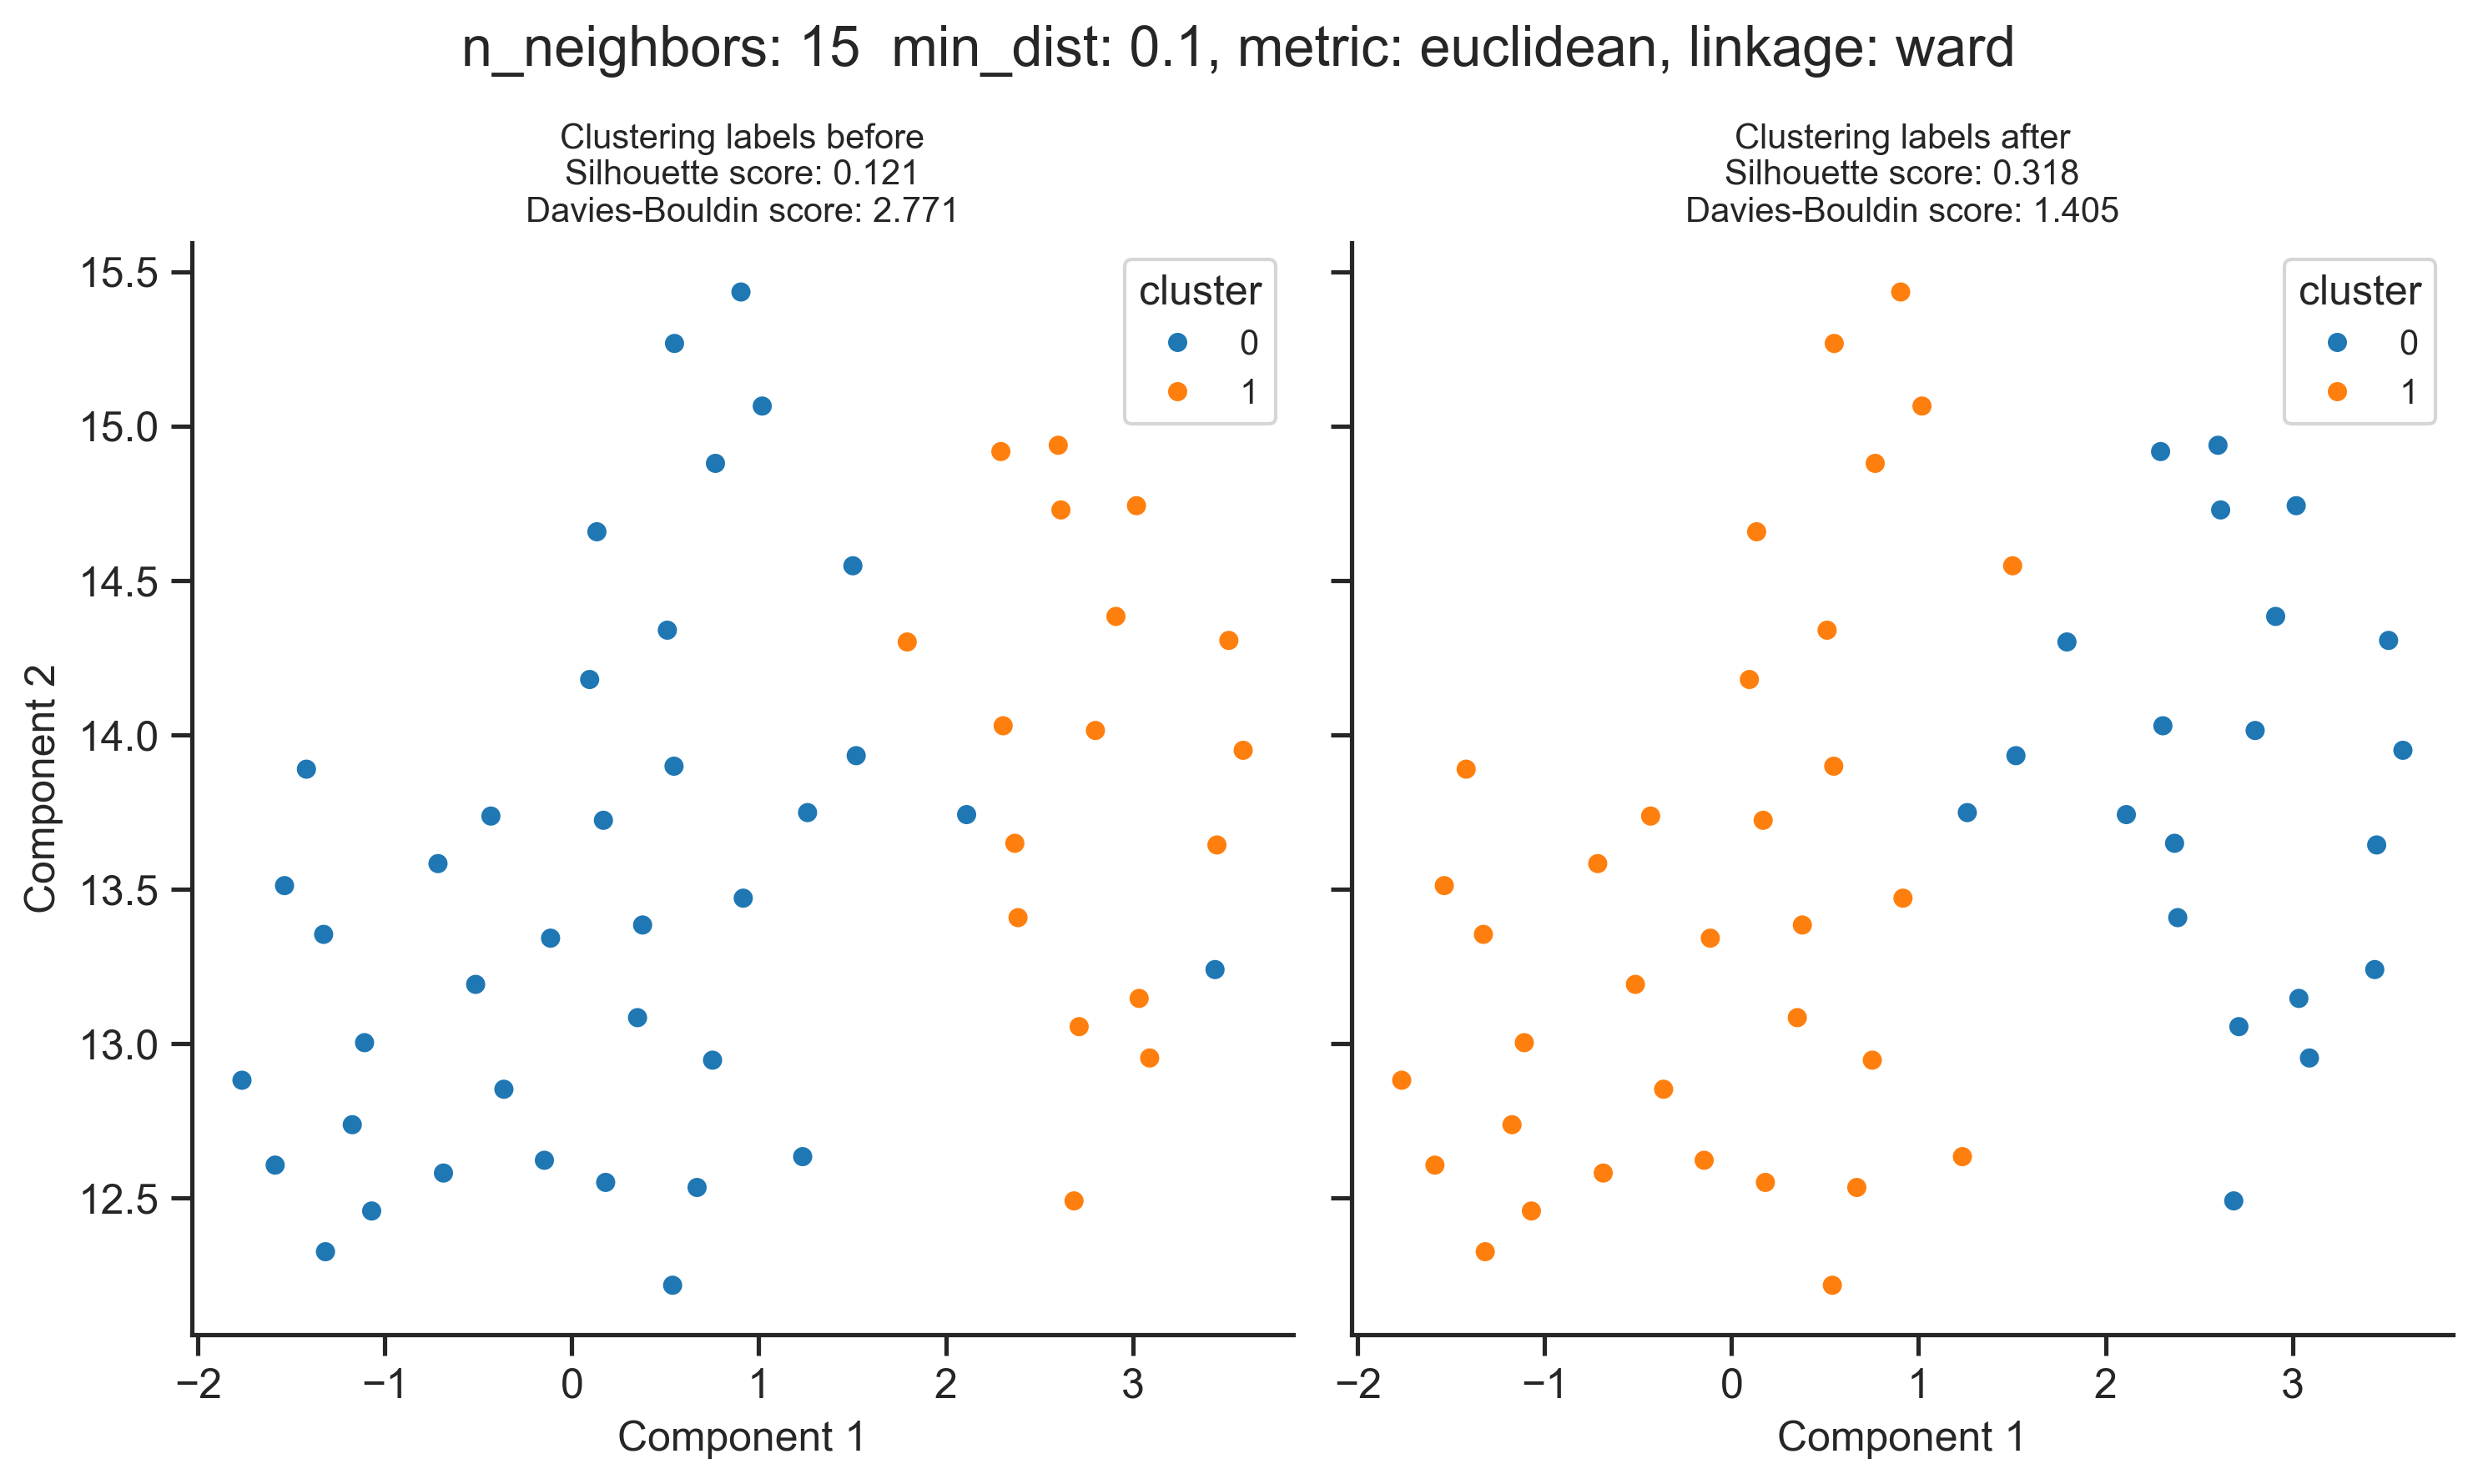

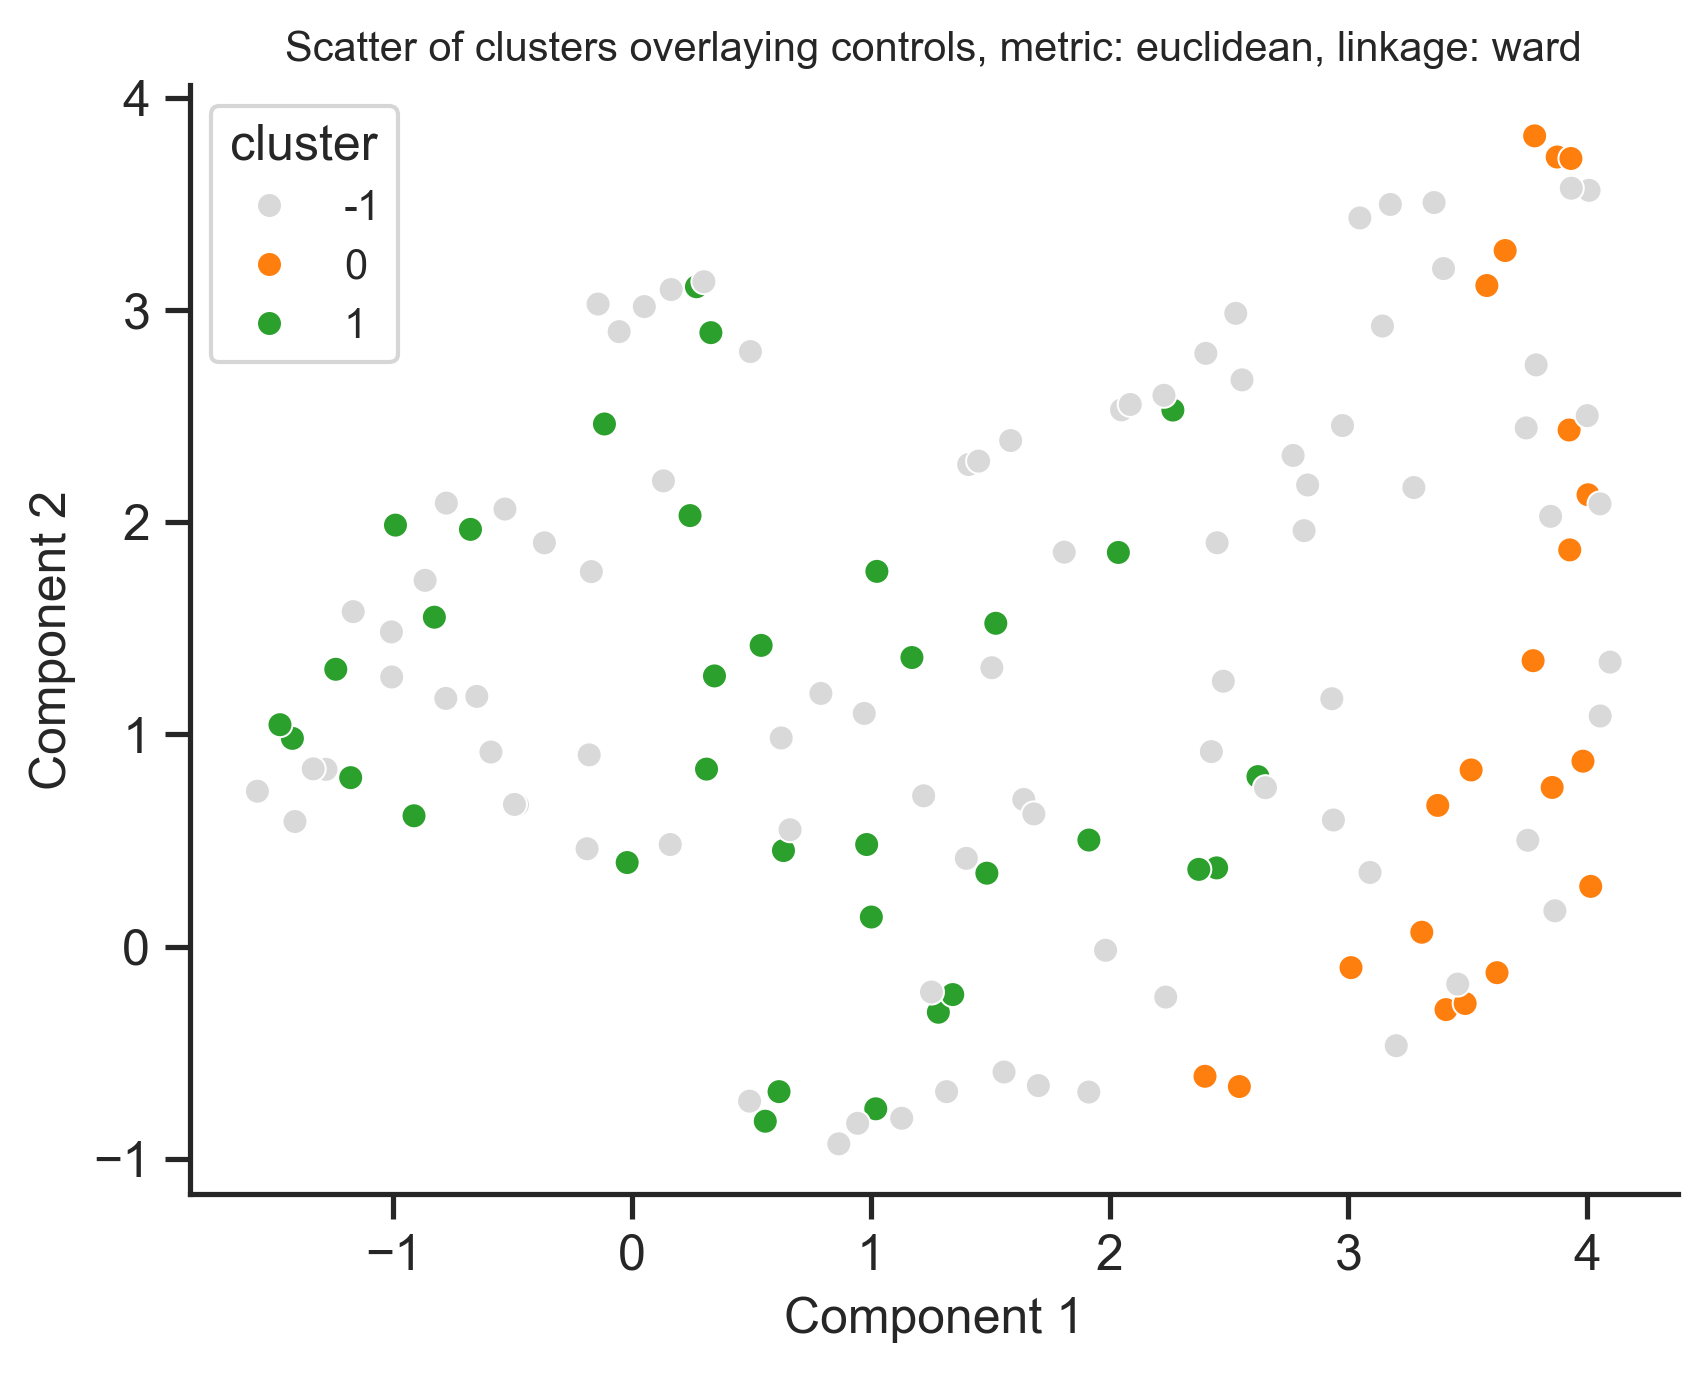

In [107]:

model = AgglomerativeClustering

metric = 'euclidean'
linkage = 'ward'
agglomerative_model_args = {'n_clusters': None, 'linkage': linkage, 'metric': metric}

clustering_results = perform_clustering(n_cluster=2, X=X_stdz, clustering_model=model, model_args=agglomerative_model_args.copy())
feature_importance_results = perform_feature_selection(X_train, X_test, clustering_results)
selected_features_results = perform_knee_locator(feature_importance_results)
plot_old_versus_new_clustering(X_stdz, selected_features_results, model, agglomerative_model_args.copy())
plt.savefig("/Users/viscom2025/Documents/images/agg_e_w_c2.png")

plot_scatter_of_clusters_with_controls(X_stdz
                                       , X_controls_stdz
                                       , selected_features_results
                                       , model 
                                       , model_args = agglomerative_model_args.copy()
                                       , title = "Scatter of clusters overlaying controls, metric: euclidean, linkage: ward")

plt.savefig("/Users/viscom2025/Documents/images/agg_e_w_c2-control_overlay.png")


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025-05-14 16:37:39,035 - INFO - 1141331686.perform_feature_selection:50 - Number of clusters: 4
2025-05-14 16:37:39,035 - INFO - 1141331686.perform_feature_selection:51 - Best model parameters: {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 30}
2025-05-14 16:37:39,036 - INFO - 1141331686.perform_feature_selection:52 - Best score: 0.818
100%|██████████| 1/1 [00:02<00:00,  2.29s/it]
2025-05-14 16:37:39,038 - INFO - 1141331686.perform_knee_locator:99 - Knee detected at feature rank 15
2025-05-14 16:37:39,039 - INFO - 1141331686.perform_knee_locator:107 - Automatically selected 16 features
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-

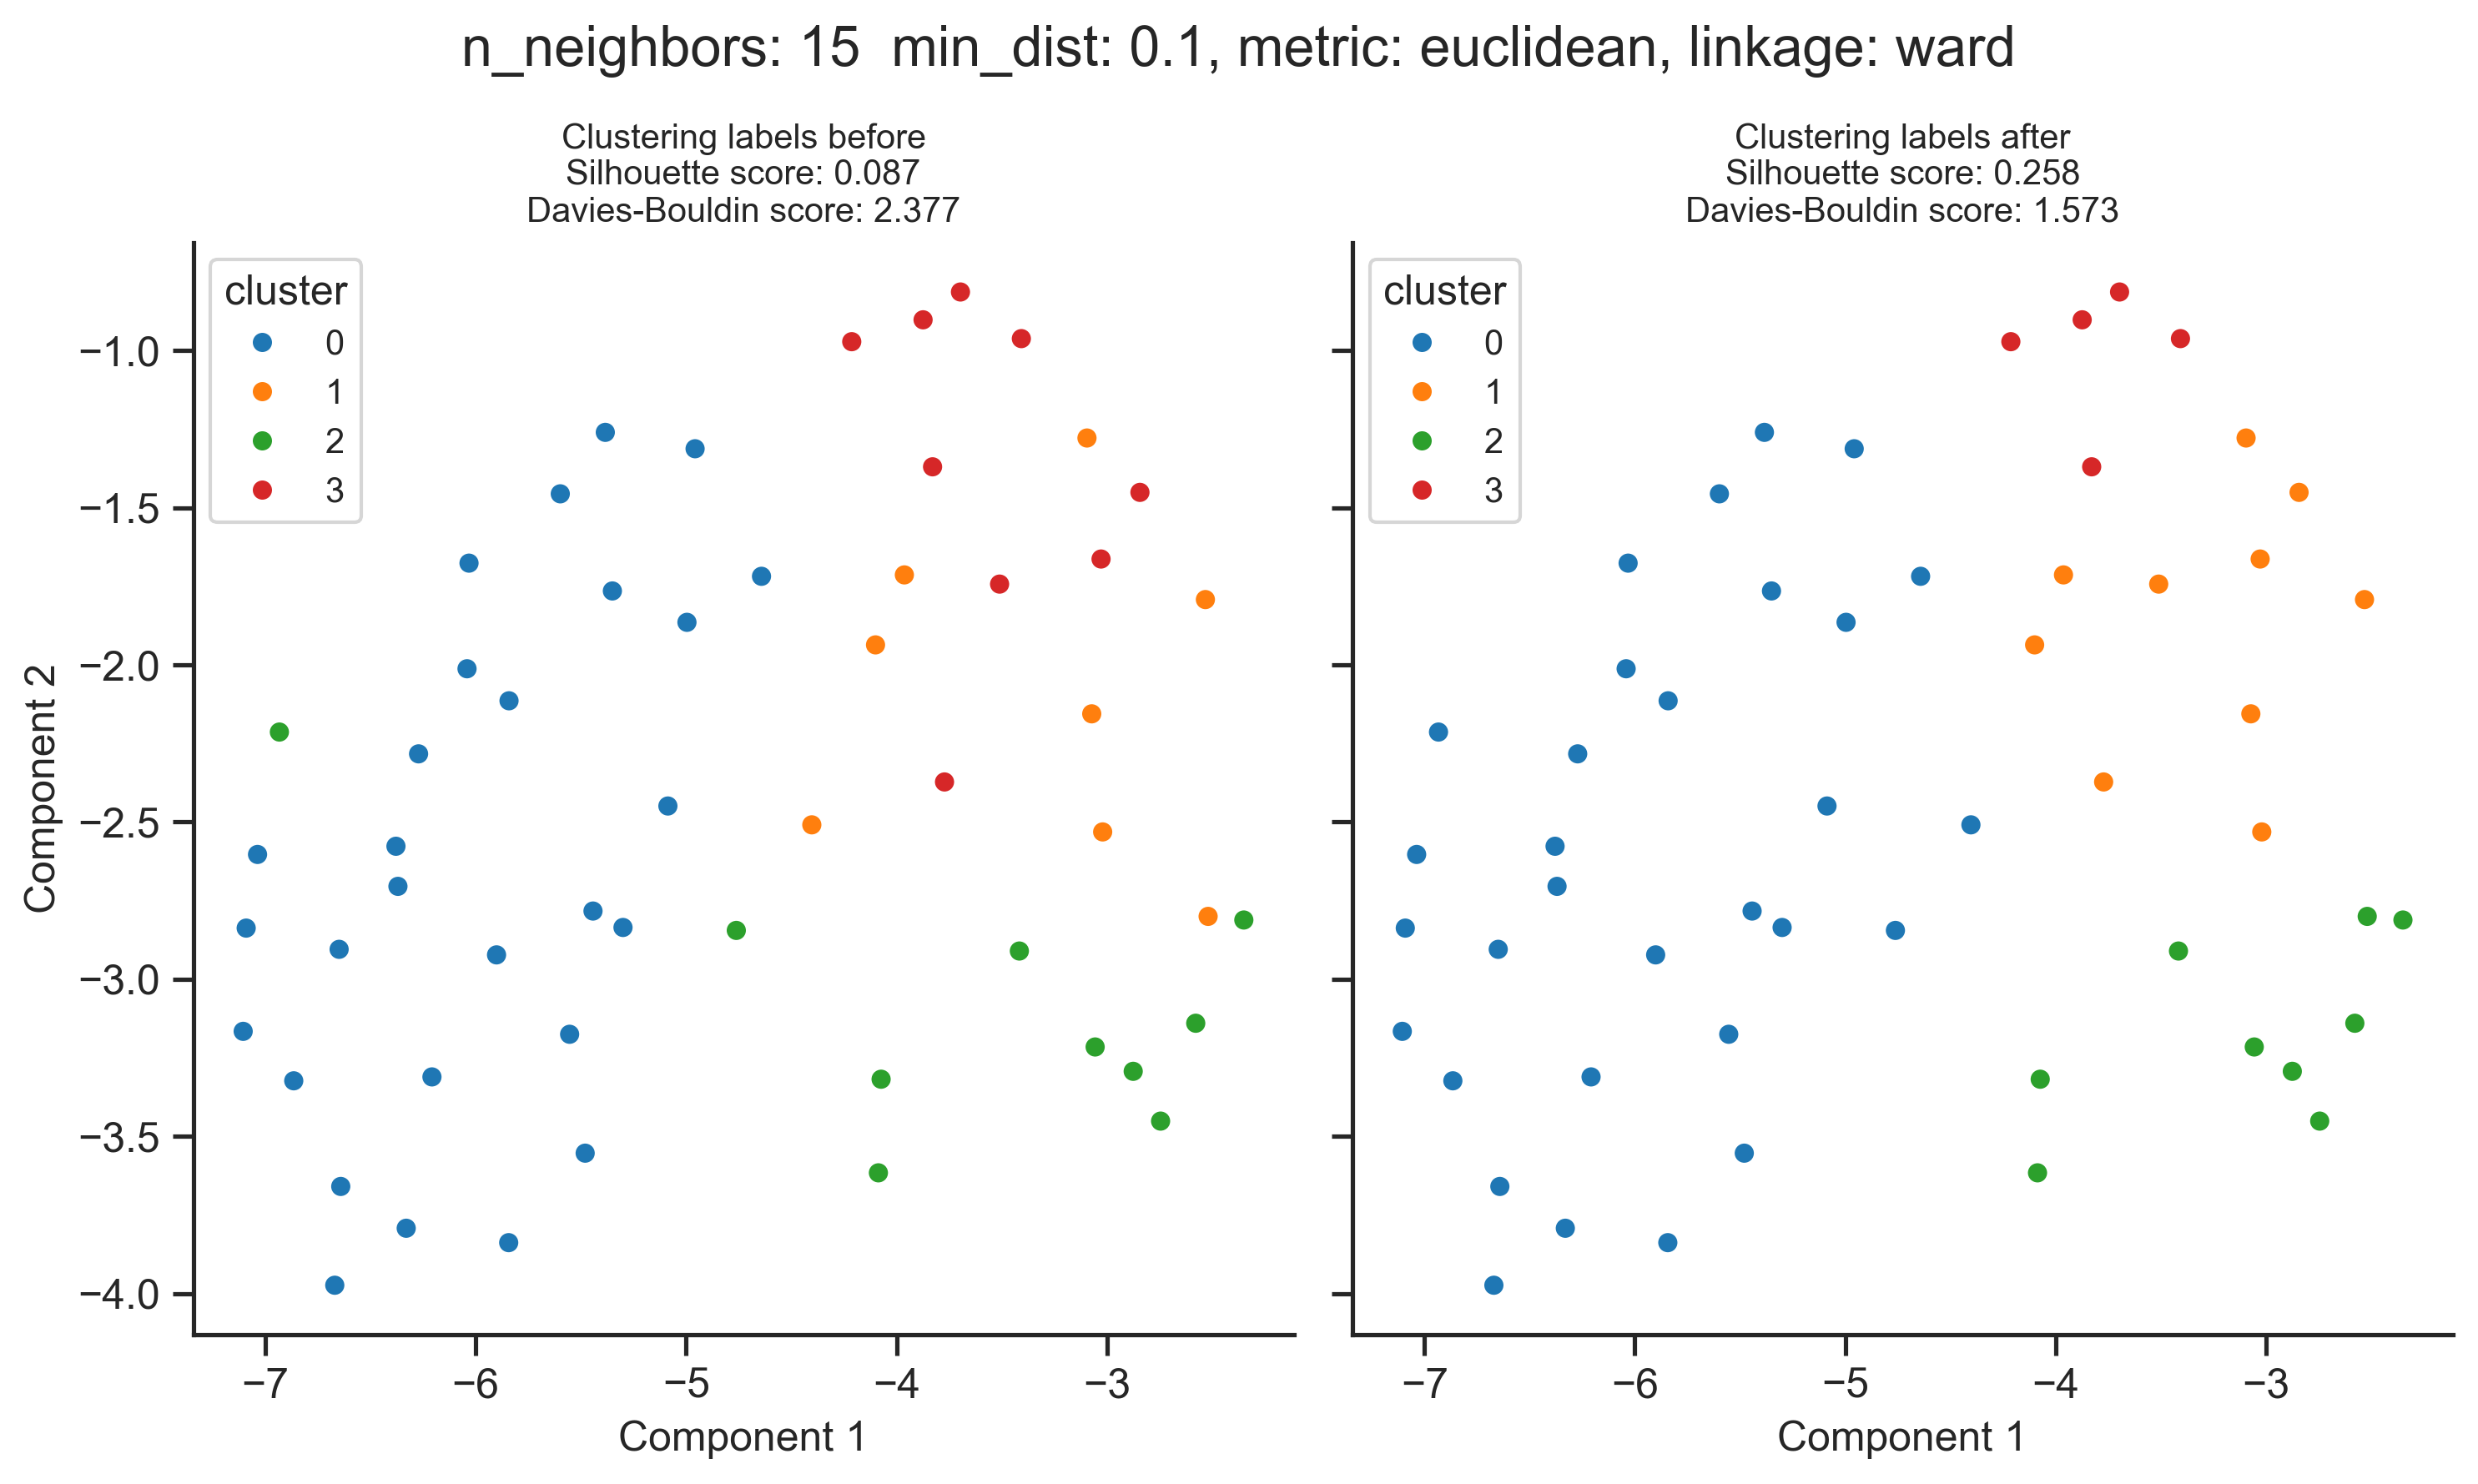

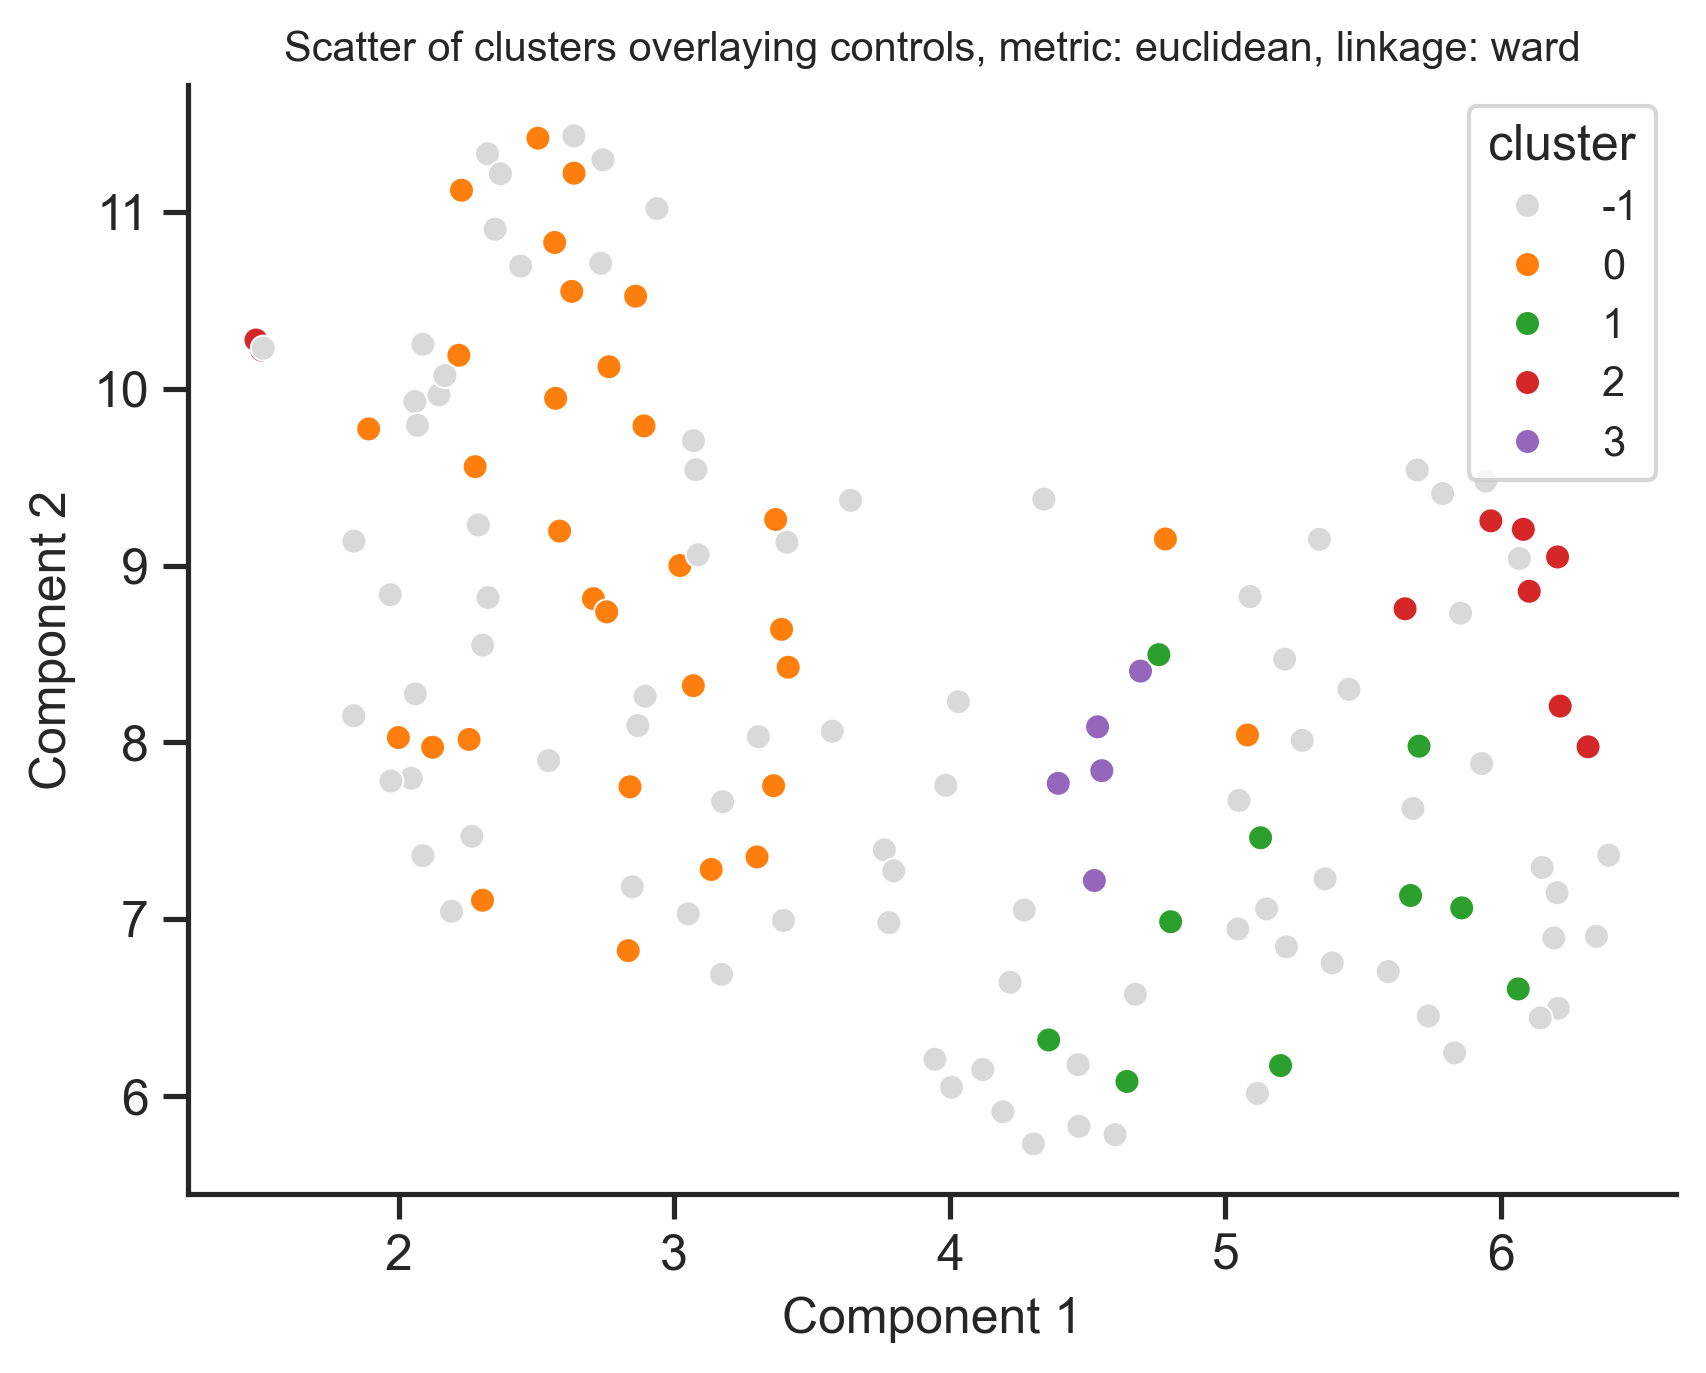

In [108]:

model = AgglomerativeClustering

metric = 'euclidean'
linkage = 'ward'
agglomerative_model_args = {'n_clusters': None, 'linkage': linkage, 'metric': metric}

clustering_results = perform_clustering(n_cluster=4, X=X_stdz, clustering_model=model, model_args=agglomerative_model_args.copy())
feature_importance_results = perform_feature_selection(X_train, X_test,clustering_results)
selected_features_results = perform_knee_locator(feature_importance_results)
plot_old_versus_new_clustering(X_stdz, selected_features_results, model, agglomerative_model_args.copy())
plt.savefig("/Users/viscom2025/Documents/images/agg_e_w_c4.png")

plot_scatter_of_clusters_with_controls(X_stdz
                                       , X_controls_stdz
                                       , selected_features_results
                                       , model 
                                       , model_args = agglomerative_model_args.copy()
                                       , title = "Scatter of clusters overlaying controls, metric: euclidean, linkage: ward")

plt.savefig("/Users/viscom2025/Documents/images/agg_e_w_c4-control_overlay.png")


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025-05-14 16:37:42,226 - INFO - 1141331686.perform_feature_selection:50 - Number of clusters: 2
2025-05-14 16:37:42,226 - INFO - 1141331686.perform_feature_selection:51 - Best model parameters: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 30}
2025-05-14 16:37:42,227 - INFO - 1141331686.perform_feature_selection:52 - Best score: 1.0
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]
2025-05-14 16:37:42,231 - INFO - 1141331686.perform_knee_locator:99 - Knee detected at feature rank 1
2025-05-14 16:37:42,231 - INFO - 1141331686.perform_knee_locator:107 - Automatically selected 2 features


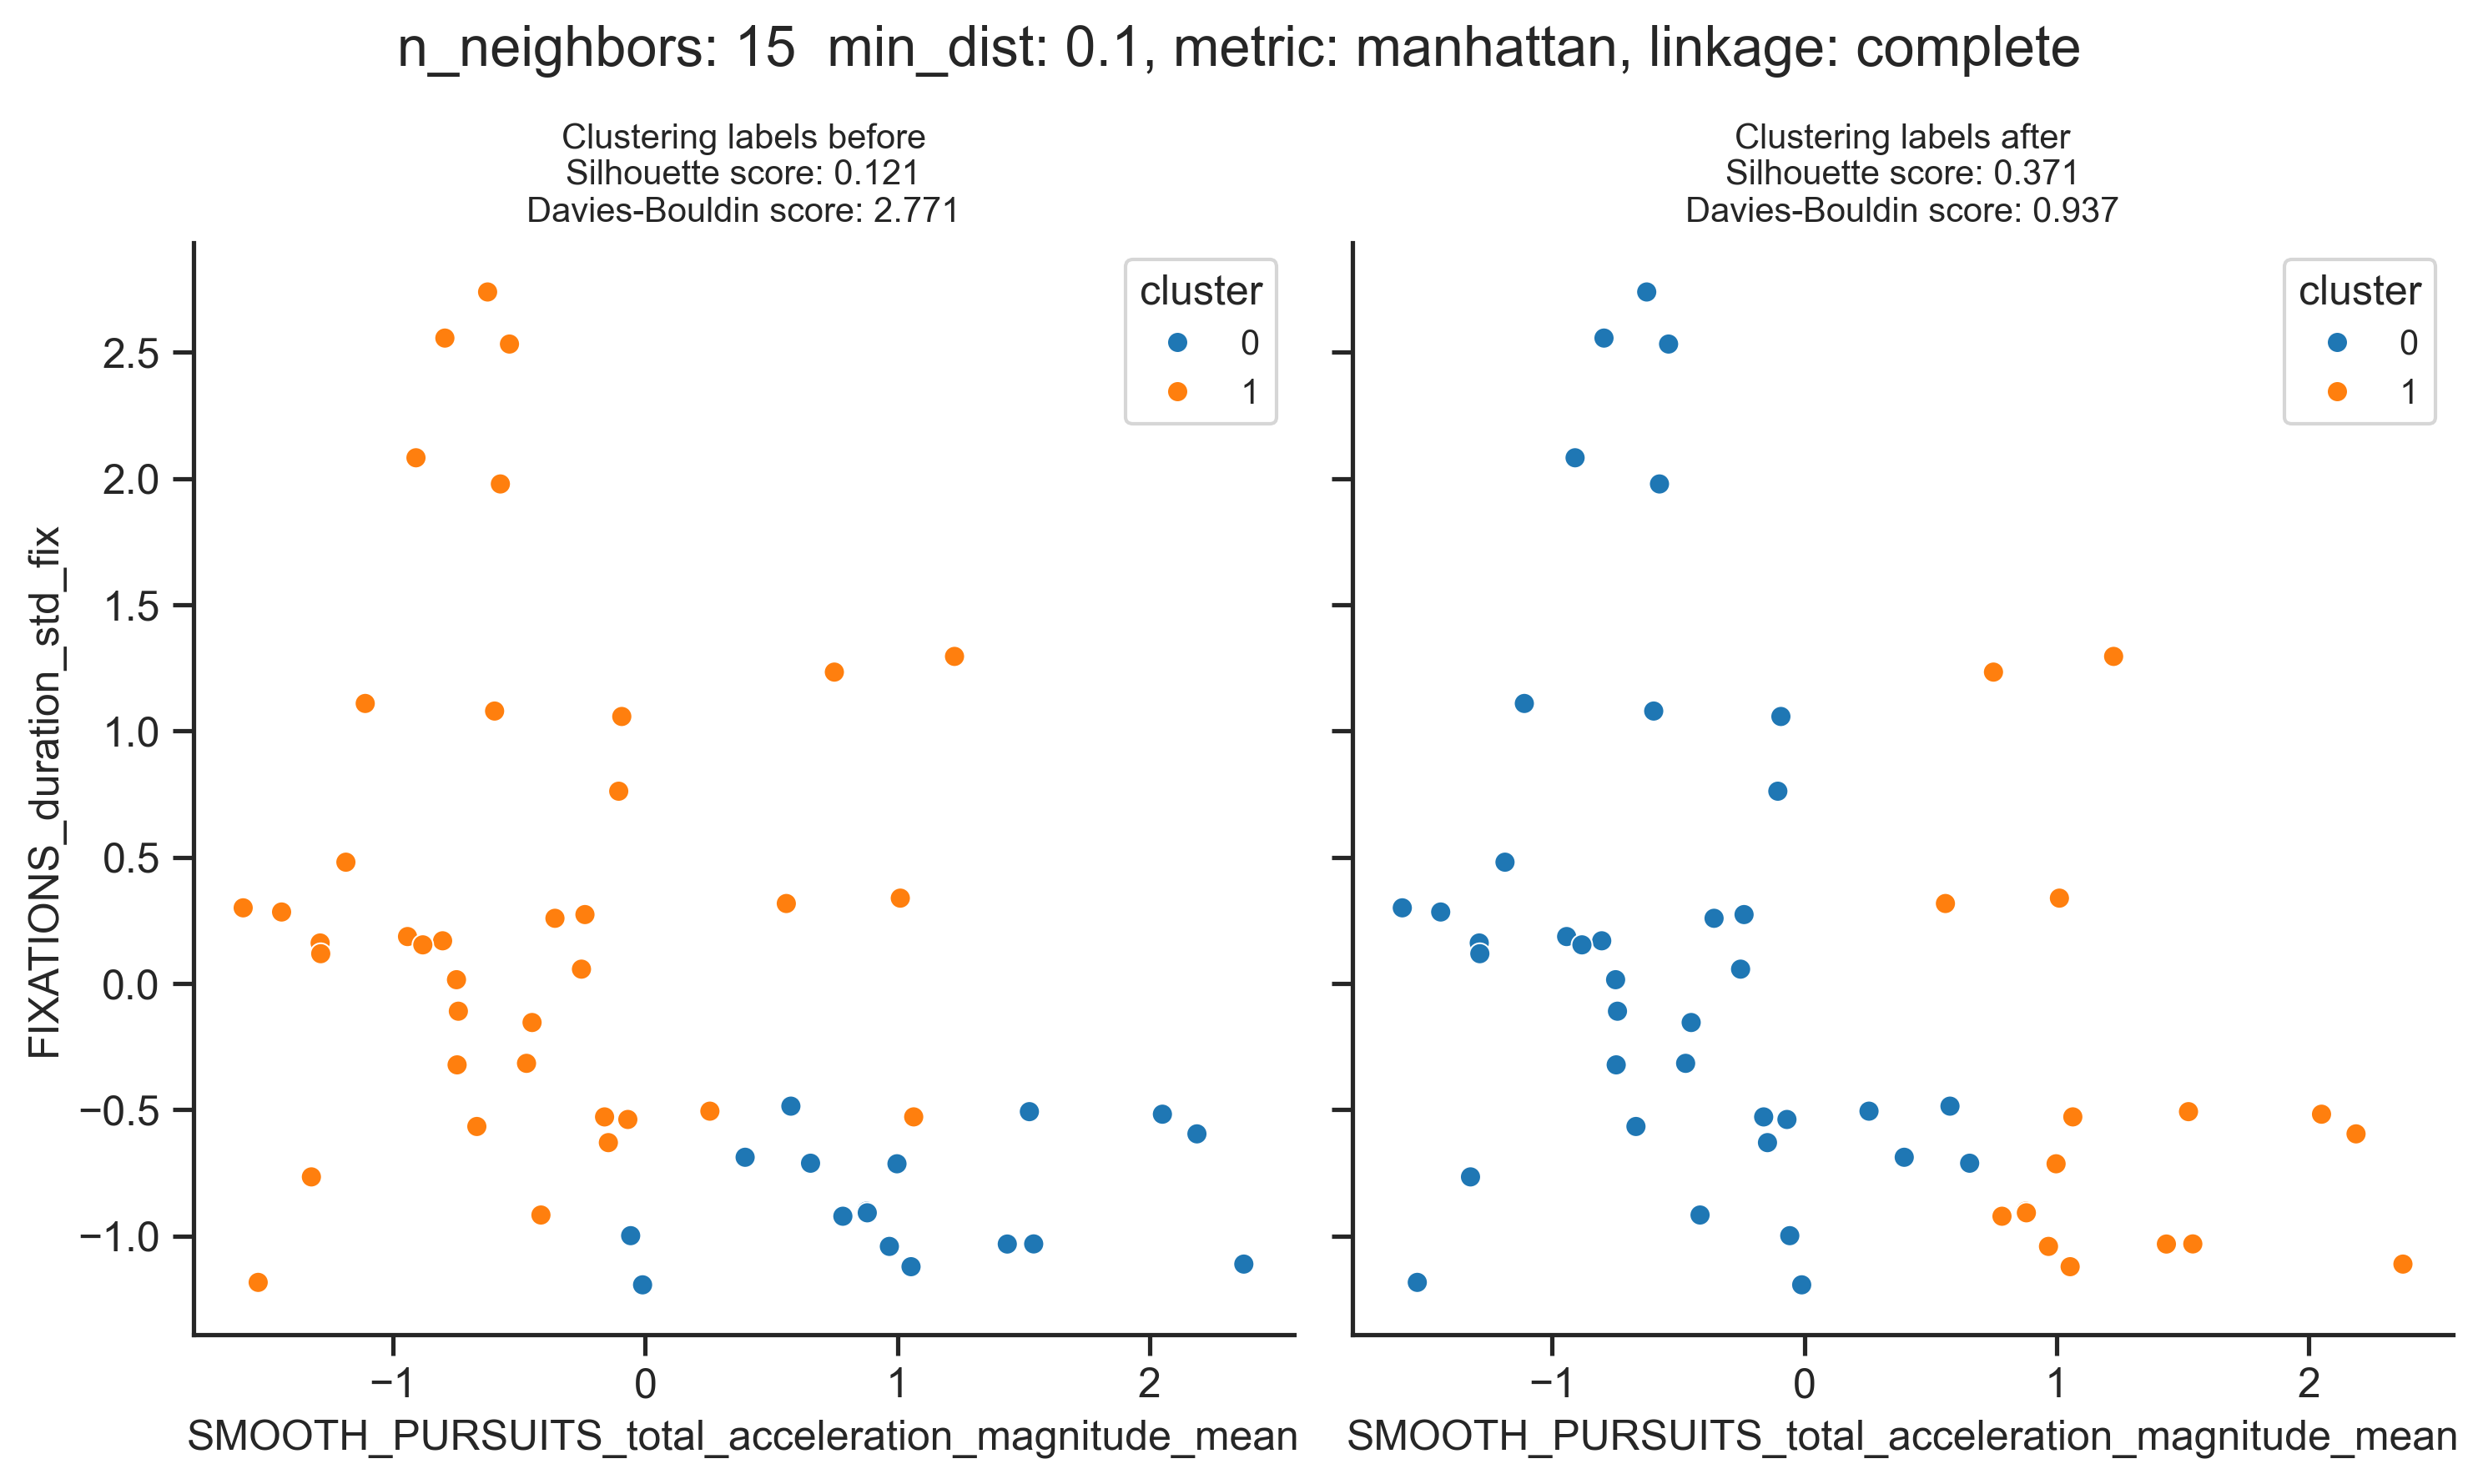

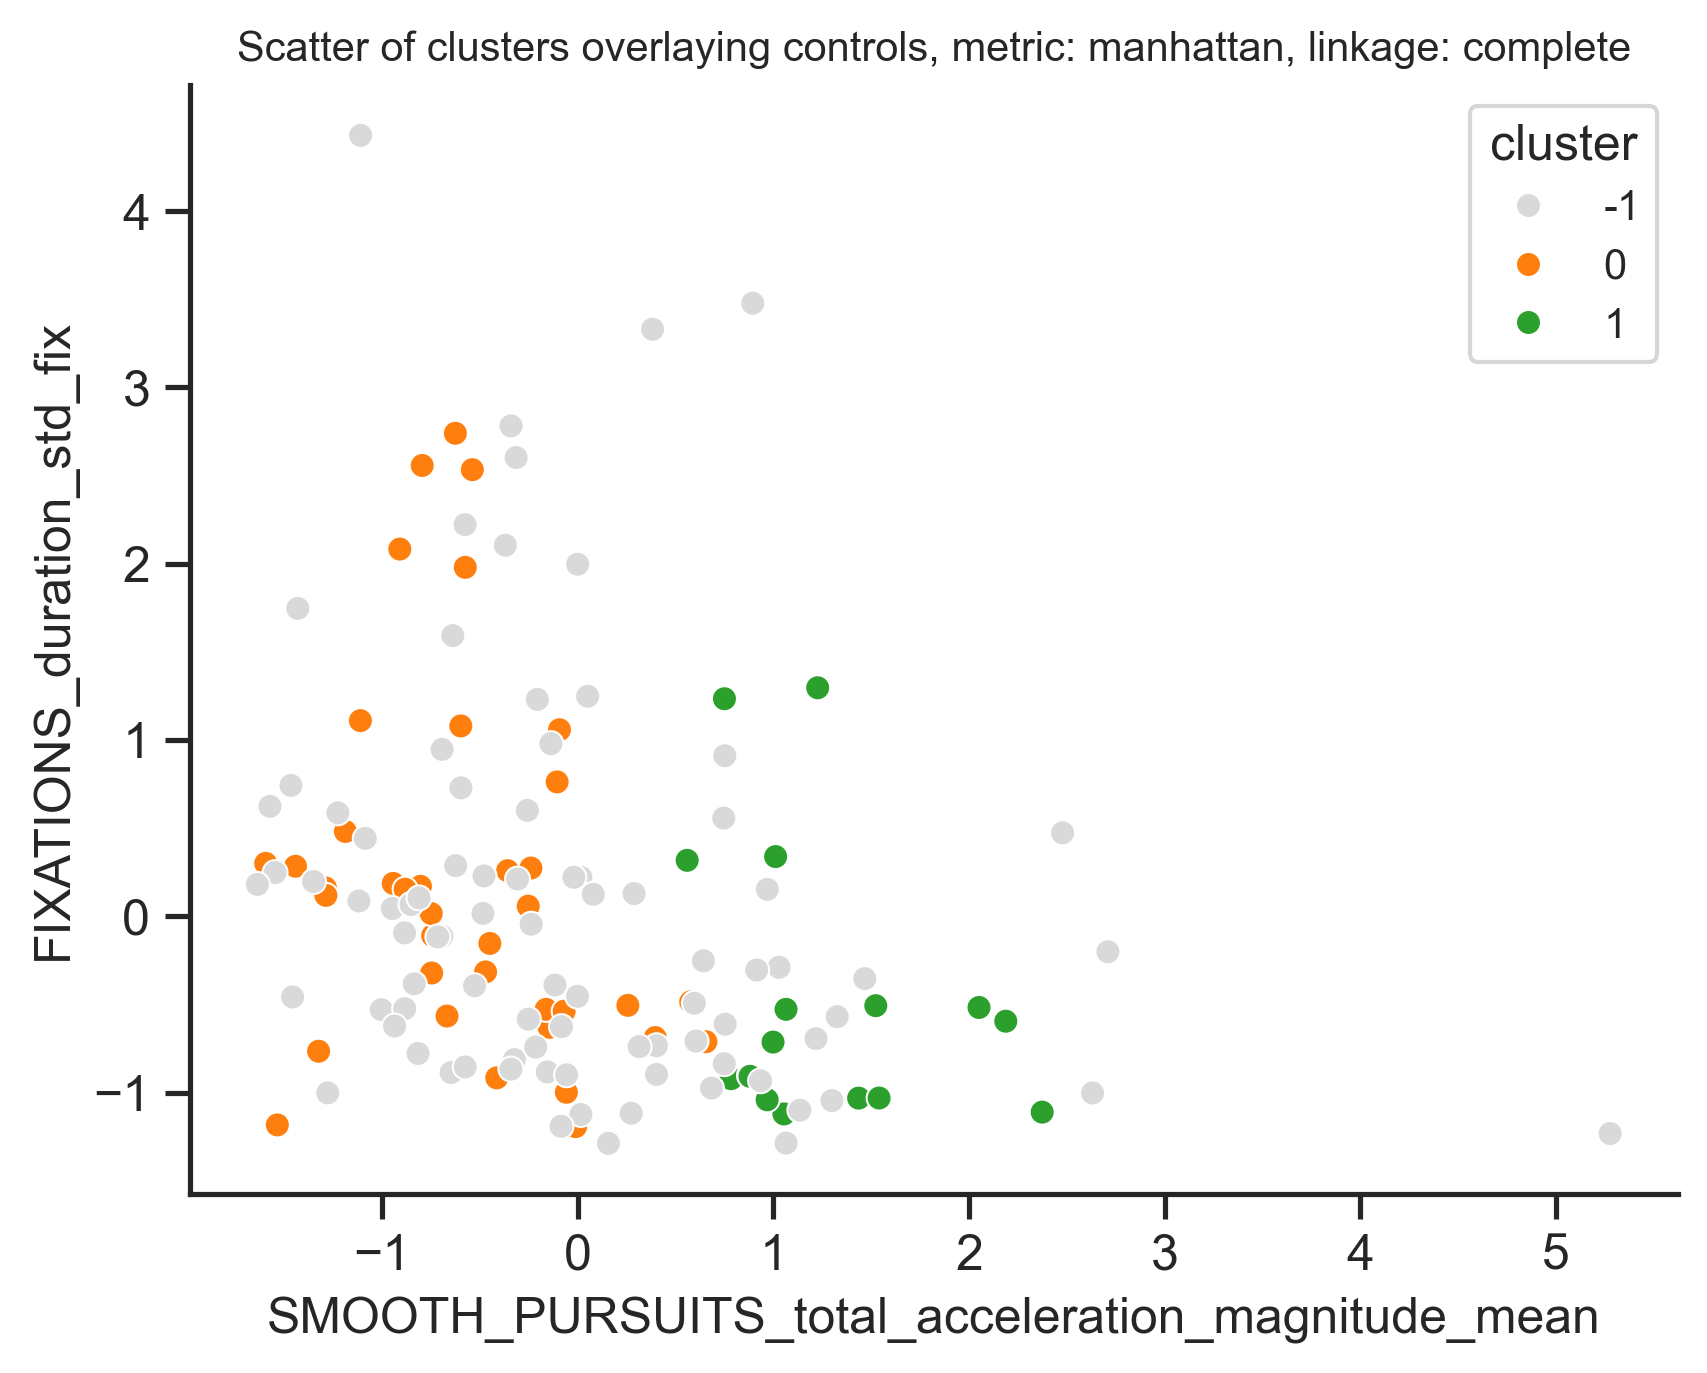

In [109]:

metric = 'manhattan'
linkage = 'complete'
agglomerative_model_args = {'n_clusters': None, 'linkage': linkage, 'metric': metric}

model = AgglomerativeClustering

clustering_results = perform_clustering(n_cluster=2, X=X_stdz, clustering_model=model, model_args=agglomerative_model_args.copy())
feature_importance_results = perform_feature_selection(X_train, X_test,clustering_results)
selected_features_results = perform_knee_locator(feature_importance_results)
plot_old_versus_new_clustering(X_stdz, selected_features_results, model, agglomerative_model_args.copy())
plt.savefig("/Users/viscom2025/Documents/images/agg_m_c_c2.png")

plot_scatter_of_clusters_with_controls(X_stdz
                                       , X_controls_stdz
                                       , selected_features_results
                                       , model 
                                       , model_args = agglomerative_model_args.copy()
                                       , title = "Scatter of clusters overlaying controls, metric: manhattan, linkage: complete")

plt.savefig("/Users/viscom2025/Documents/images/agg_m_c_c2-control_overlay.png")



  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025-05-14 16:37:45,257 - INFO - 1141331686.perform_feature_selection:50 - Number of clusters: 3
2025-05-14 16:37:45,258 - INFO - 1141331686.perform_feature_selection:51 - Best model parameters: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 20}
2025-05-14 16:37:45,258 - INFO - 1141331686.perform_feature_selection:52 - Best score: 1.0
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]
2025-05-14 16:37:45,261 - INFO - 1141331686.perform_knee_locator:99 - Knee detected at feature rank 12
2025-05-14 16:37:45,261 - INFO - 1141331686.perform_knee_locator:107 - Automatically selected 13 features
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-pa

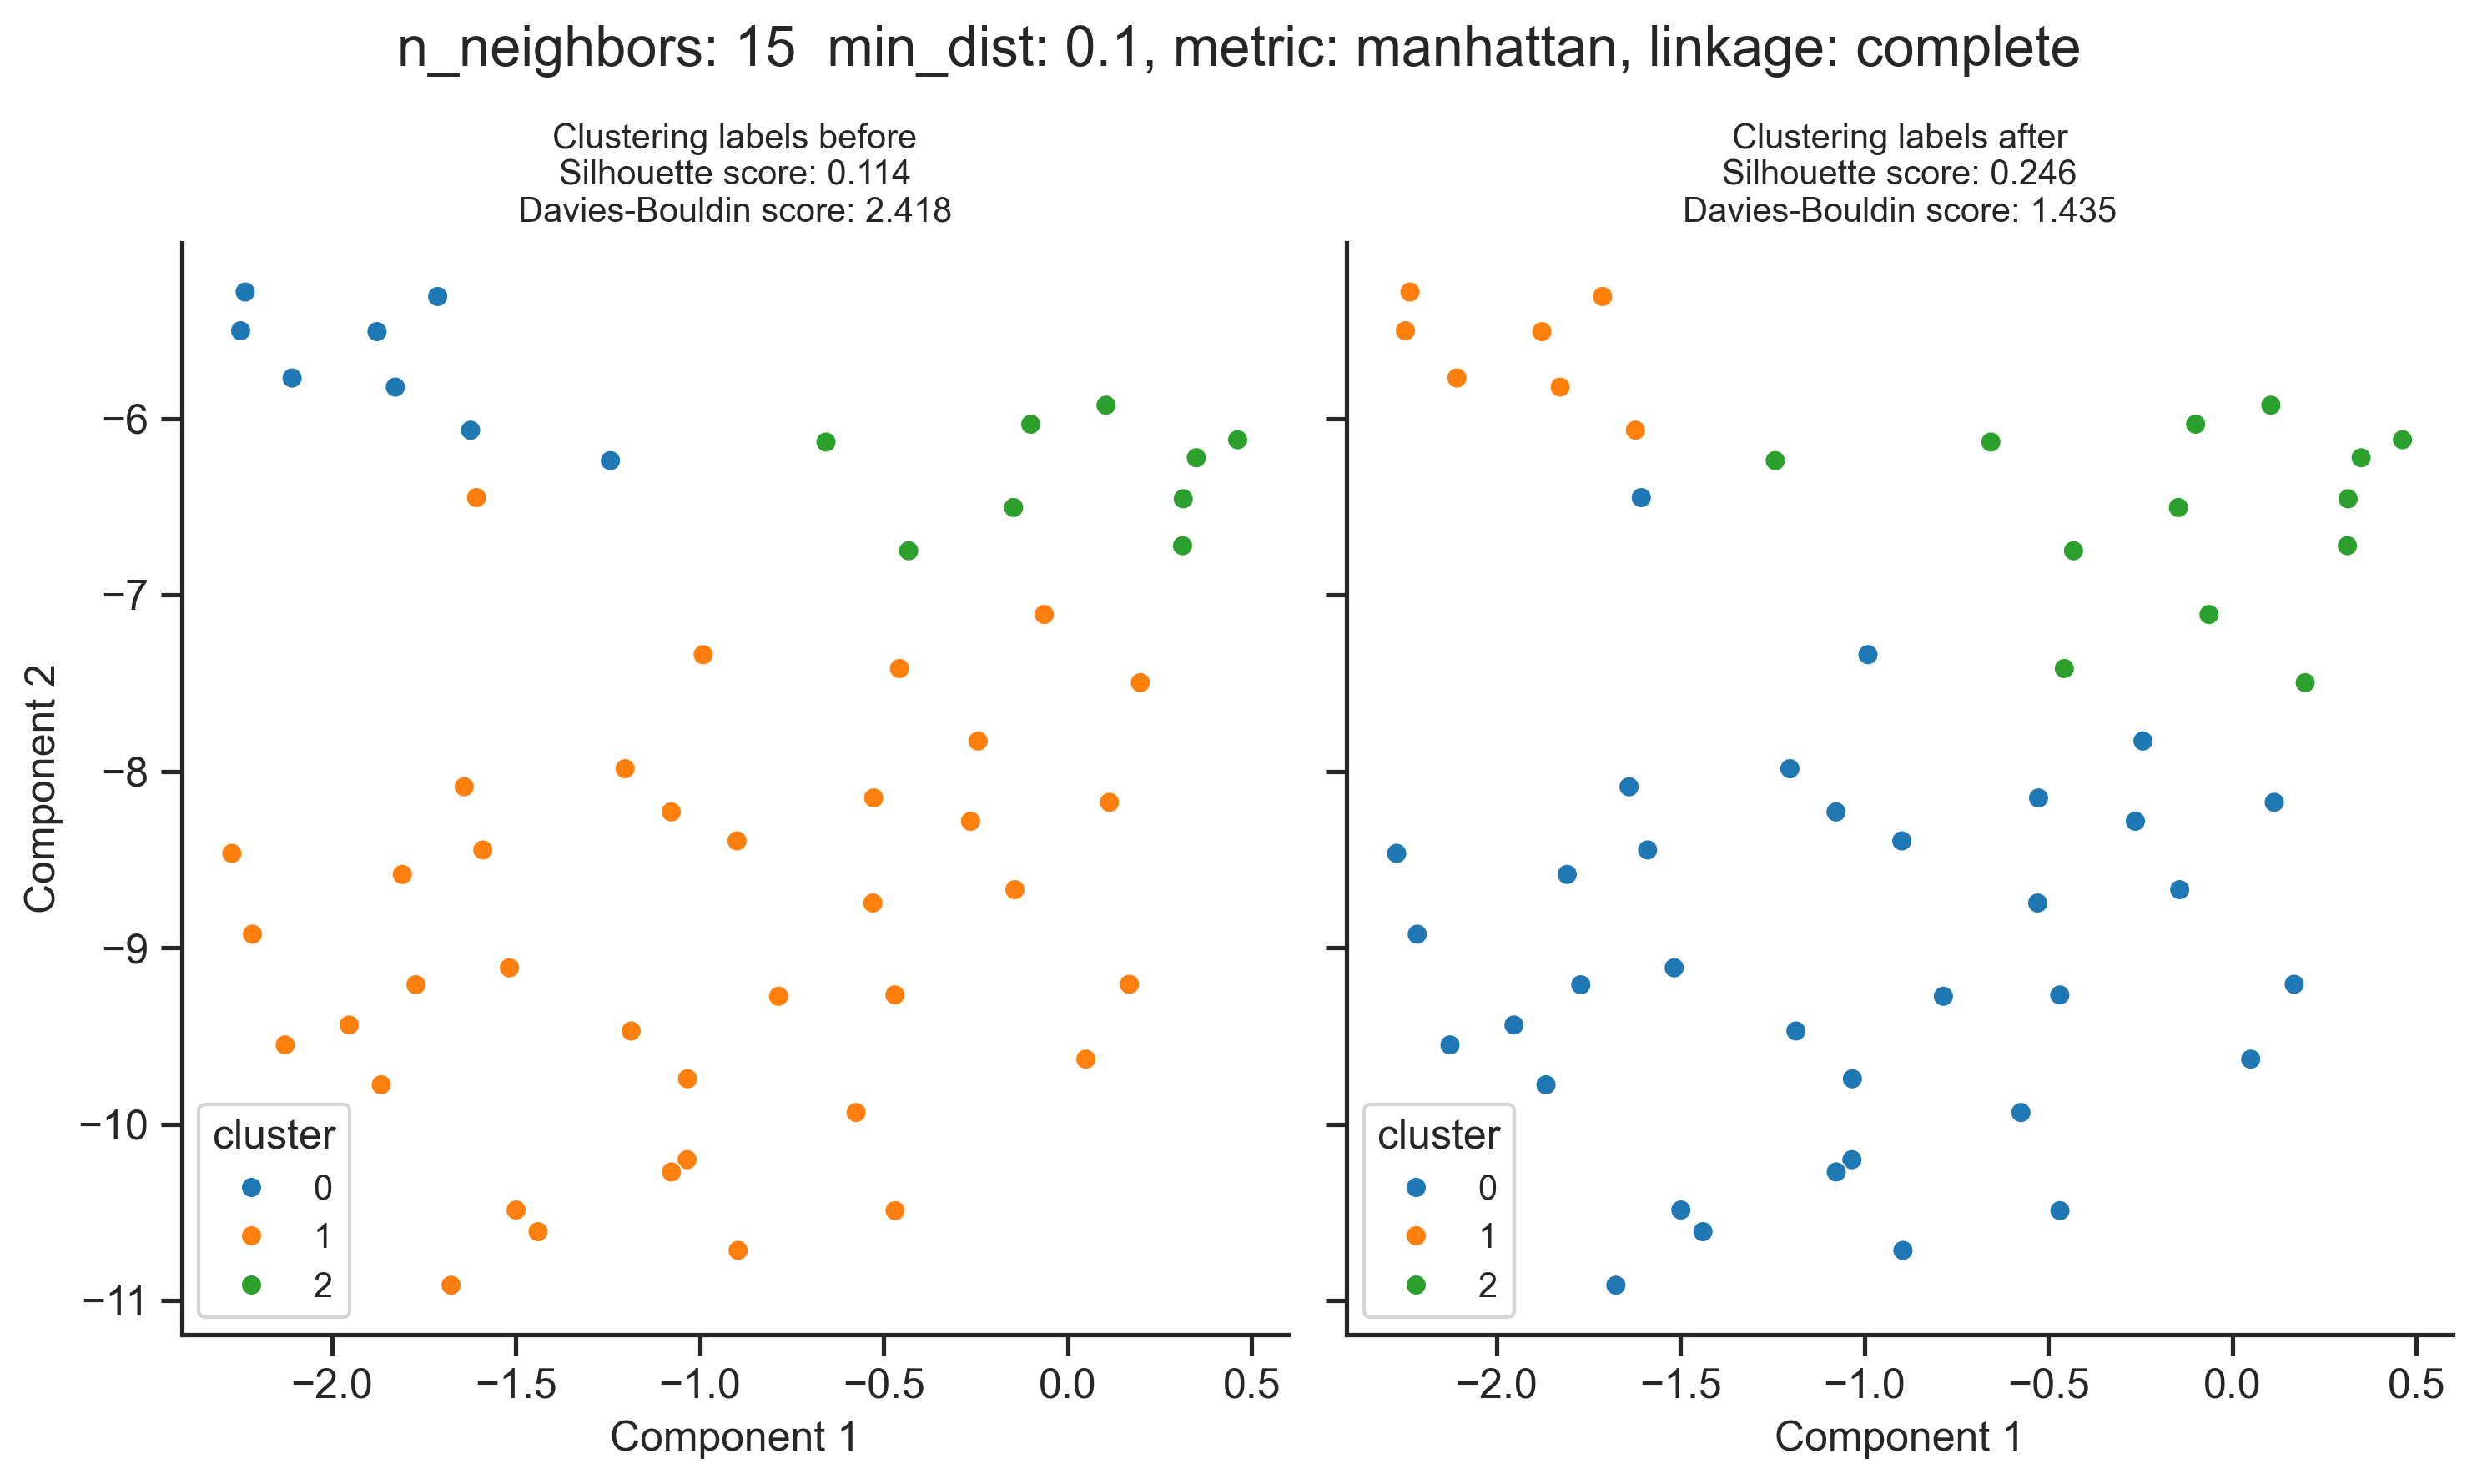

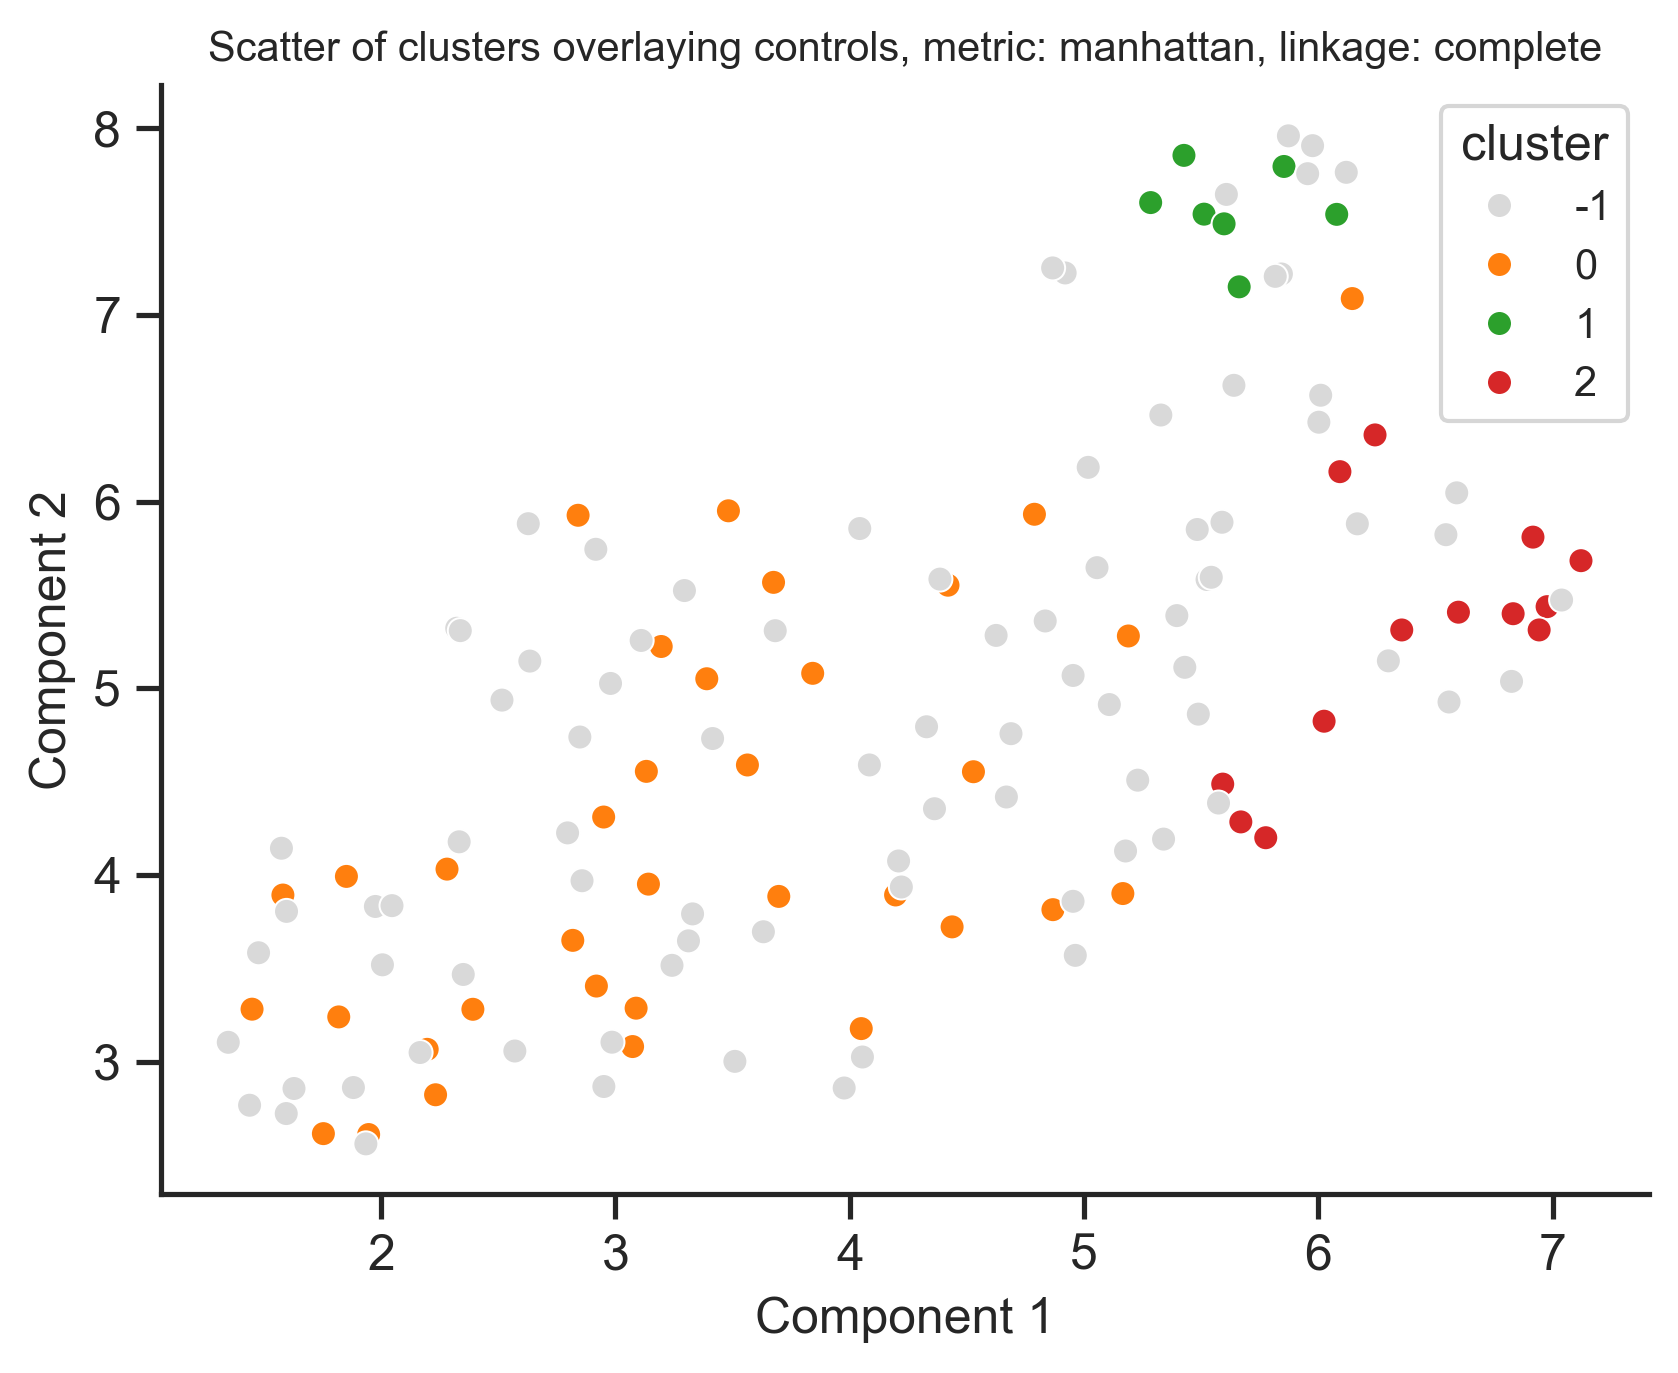

In [110]:

metric = 'manhattan'
linkage = 'complete'
agglomerative_model_args = {'n_clusters': None, 'linkage': linkage, 'metric': metric}

model = AgglomerativeClustering

clustering_results = perform_clustering(n_cluster=3, X=X_stdz, clustering_model=model, model_args=agglomerative_model_args.copy())
feature_importance_results = perform_feature_selection(X_train, X_test,clustering_results)
selected_features_results = perform_knee_locator(feature_importance_results)
plot_old_versus_new_clustering(X_stdz, selected_features_results, model, agglomerative_model_args.copy())
plt.savefig("/Users/viscom2025/Documents/images/agg_m_c_c3.png")


plot_scatter_of_clusters_with_controls(X_stdz
                                       , X_controls_stdz
                                       , selected_features_results
                                       , model 
                                       , model_args = agglomerative_model_args.copy()
                                       , title = "Scatter of clusters overlaying controls, metric: manhattan, linkage: complete")

plt.savefig("/Users/viscom2025/Documents/images/agg_m_c_c3-control_overlay.png")

  0%|          | 0/1 [00:00<?, ?it/s]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025-05-14 16:37:48,546 - INFO - 1141331686.perform_feature_selection:50 - Number of clusters: 4
2025-05-14 16:37:48,547 - INFO - 1141331686.perform_feature_selection:51 - Best model parameters: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 30}
2025-05-14 16:37:48,547 - INFO - 1141331686.perform_feature_selection:52 - Best score: 0.909
100%|██████████| 1/1 [00:02<00:00,  2.40s/it]
2025-05-14 16:37:48,550 - INFO - 1141331686.perform_knee_locator:99 - Knee detected at feature rank 11
2025-05-14 16:37:48,551 - INFO - 1141331686.perform_knee_locator:107 - Automatically selected 12 features
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-

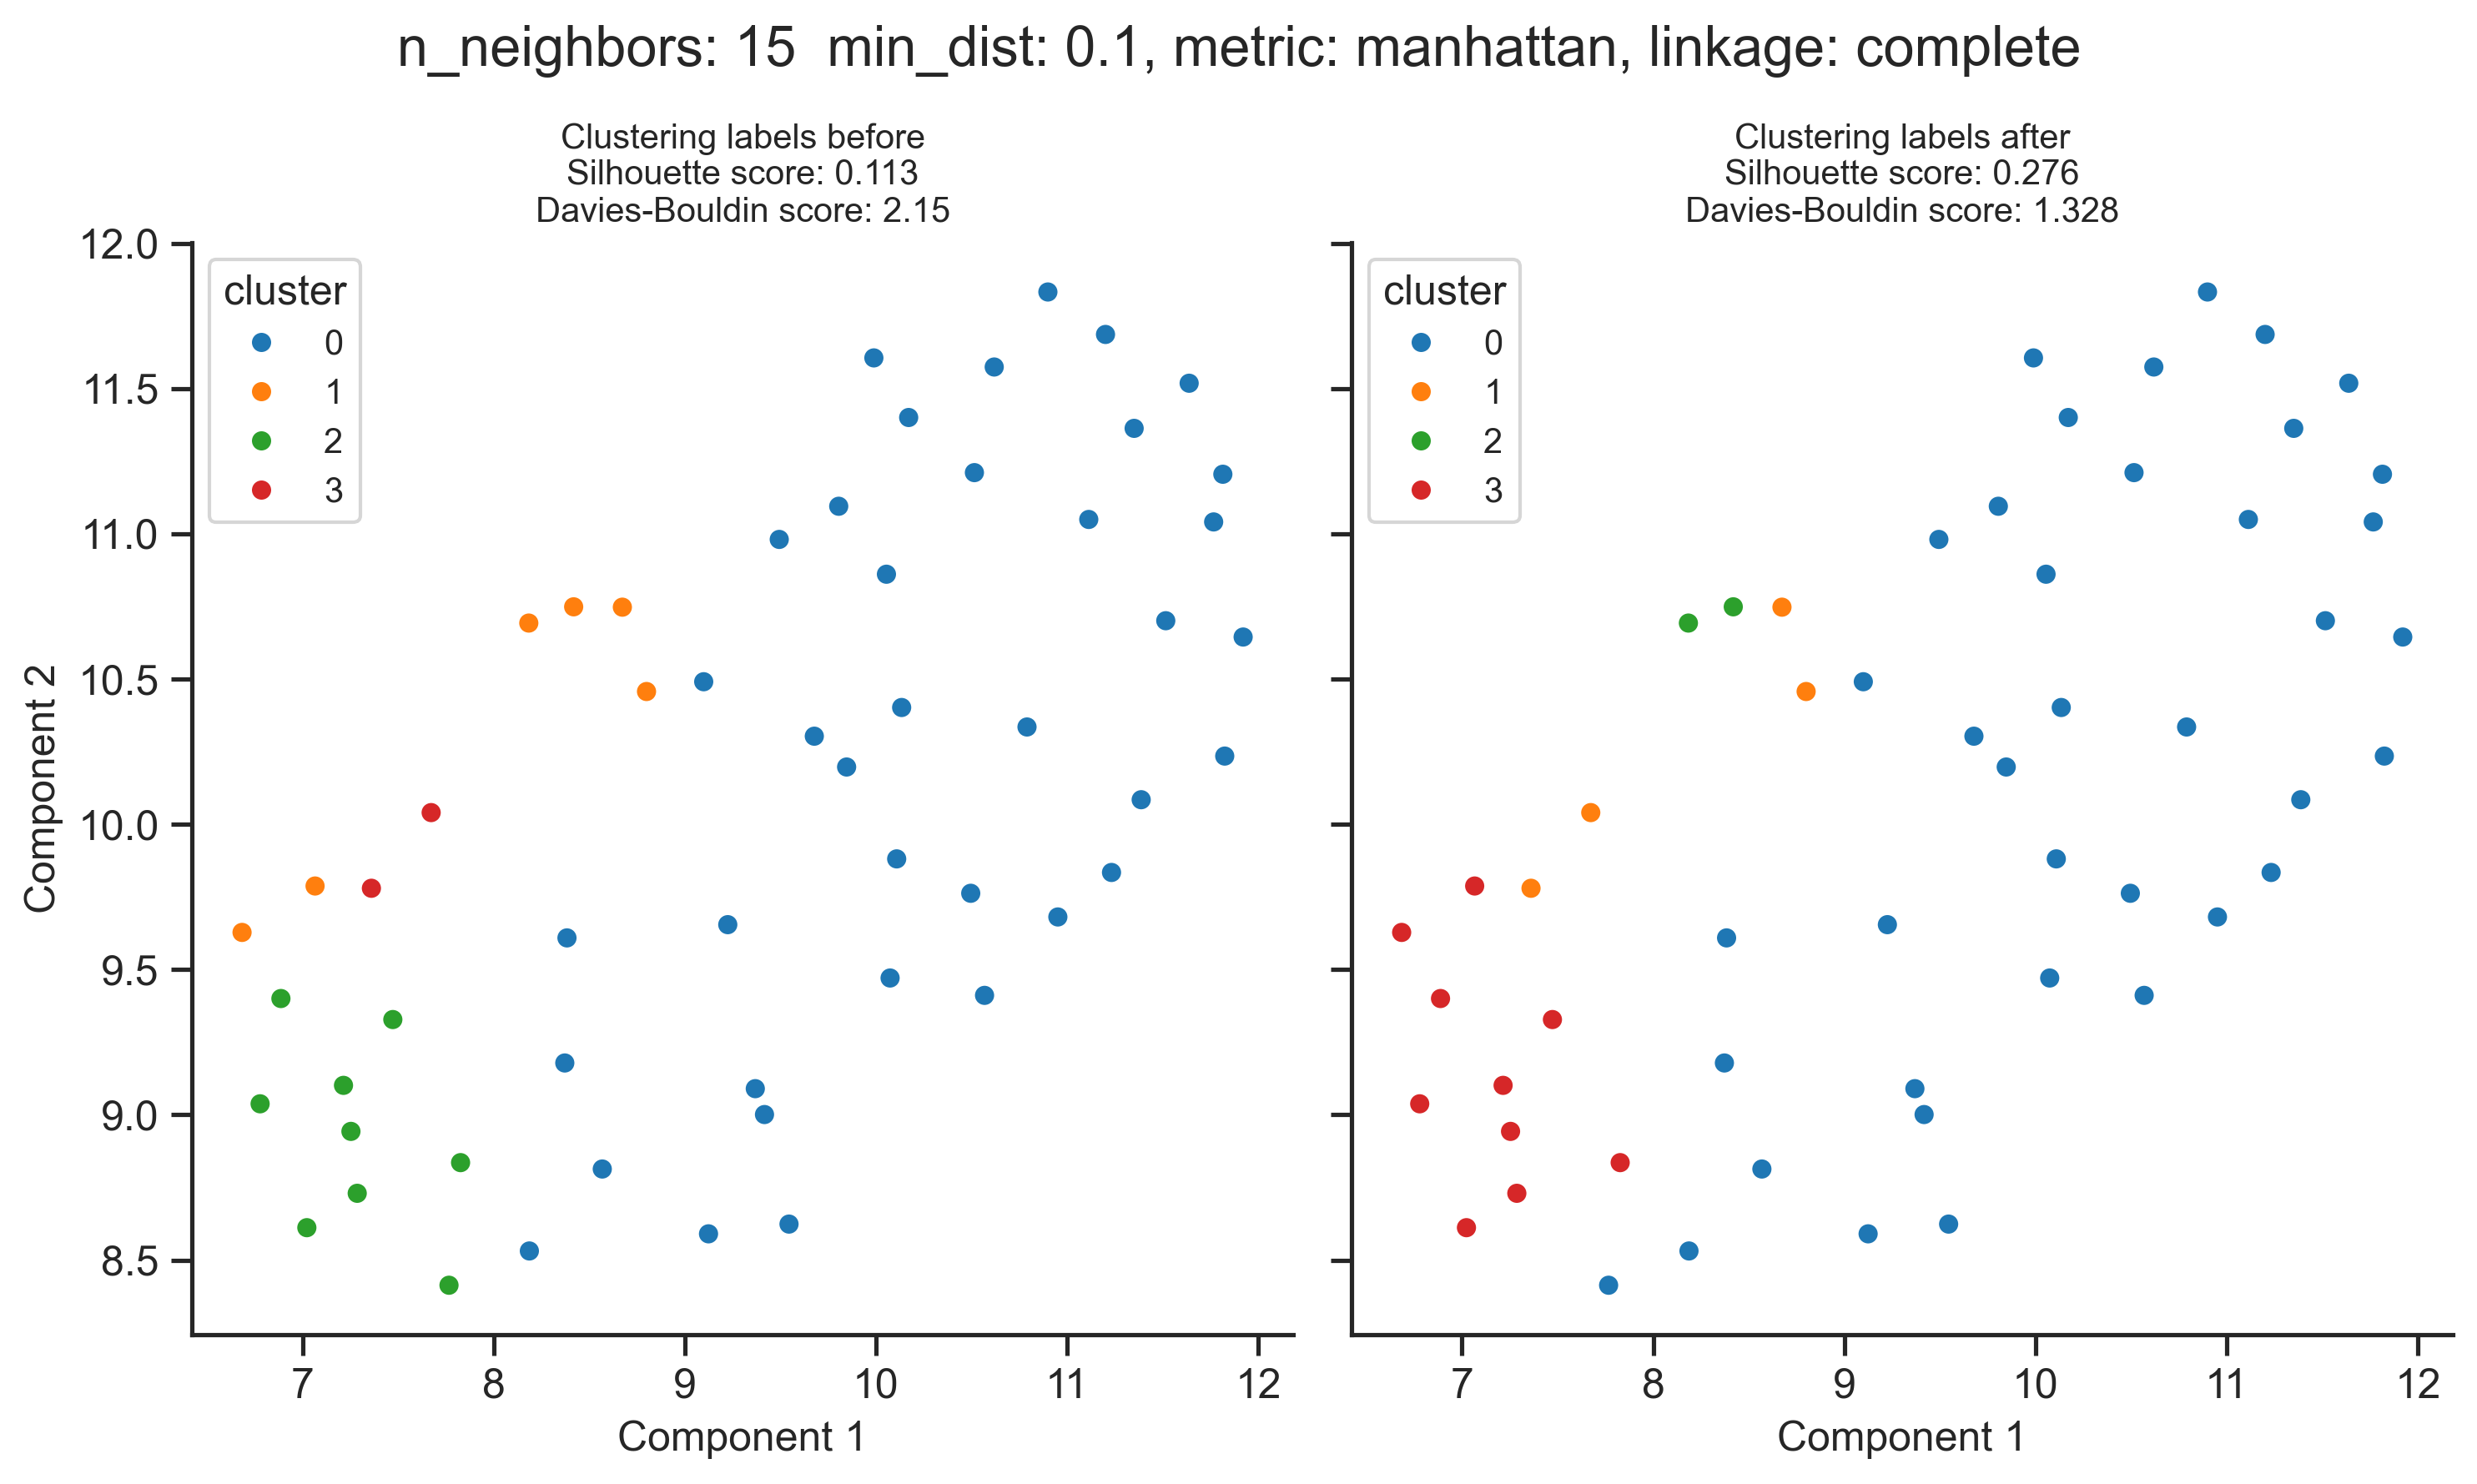

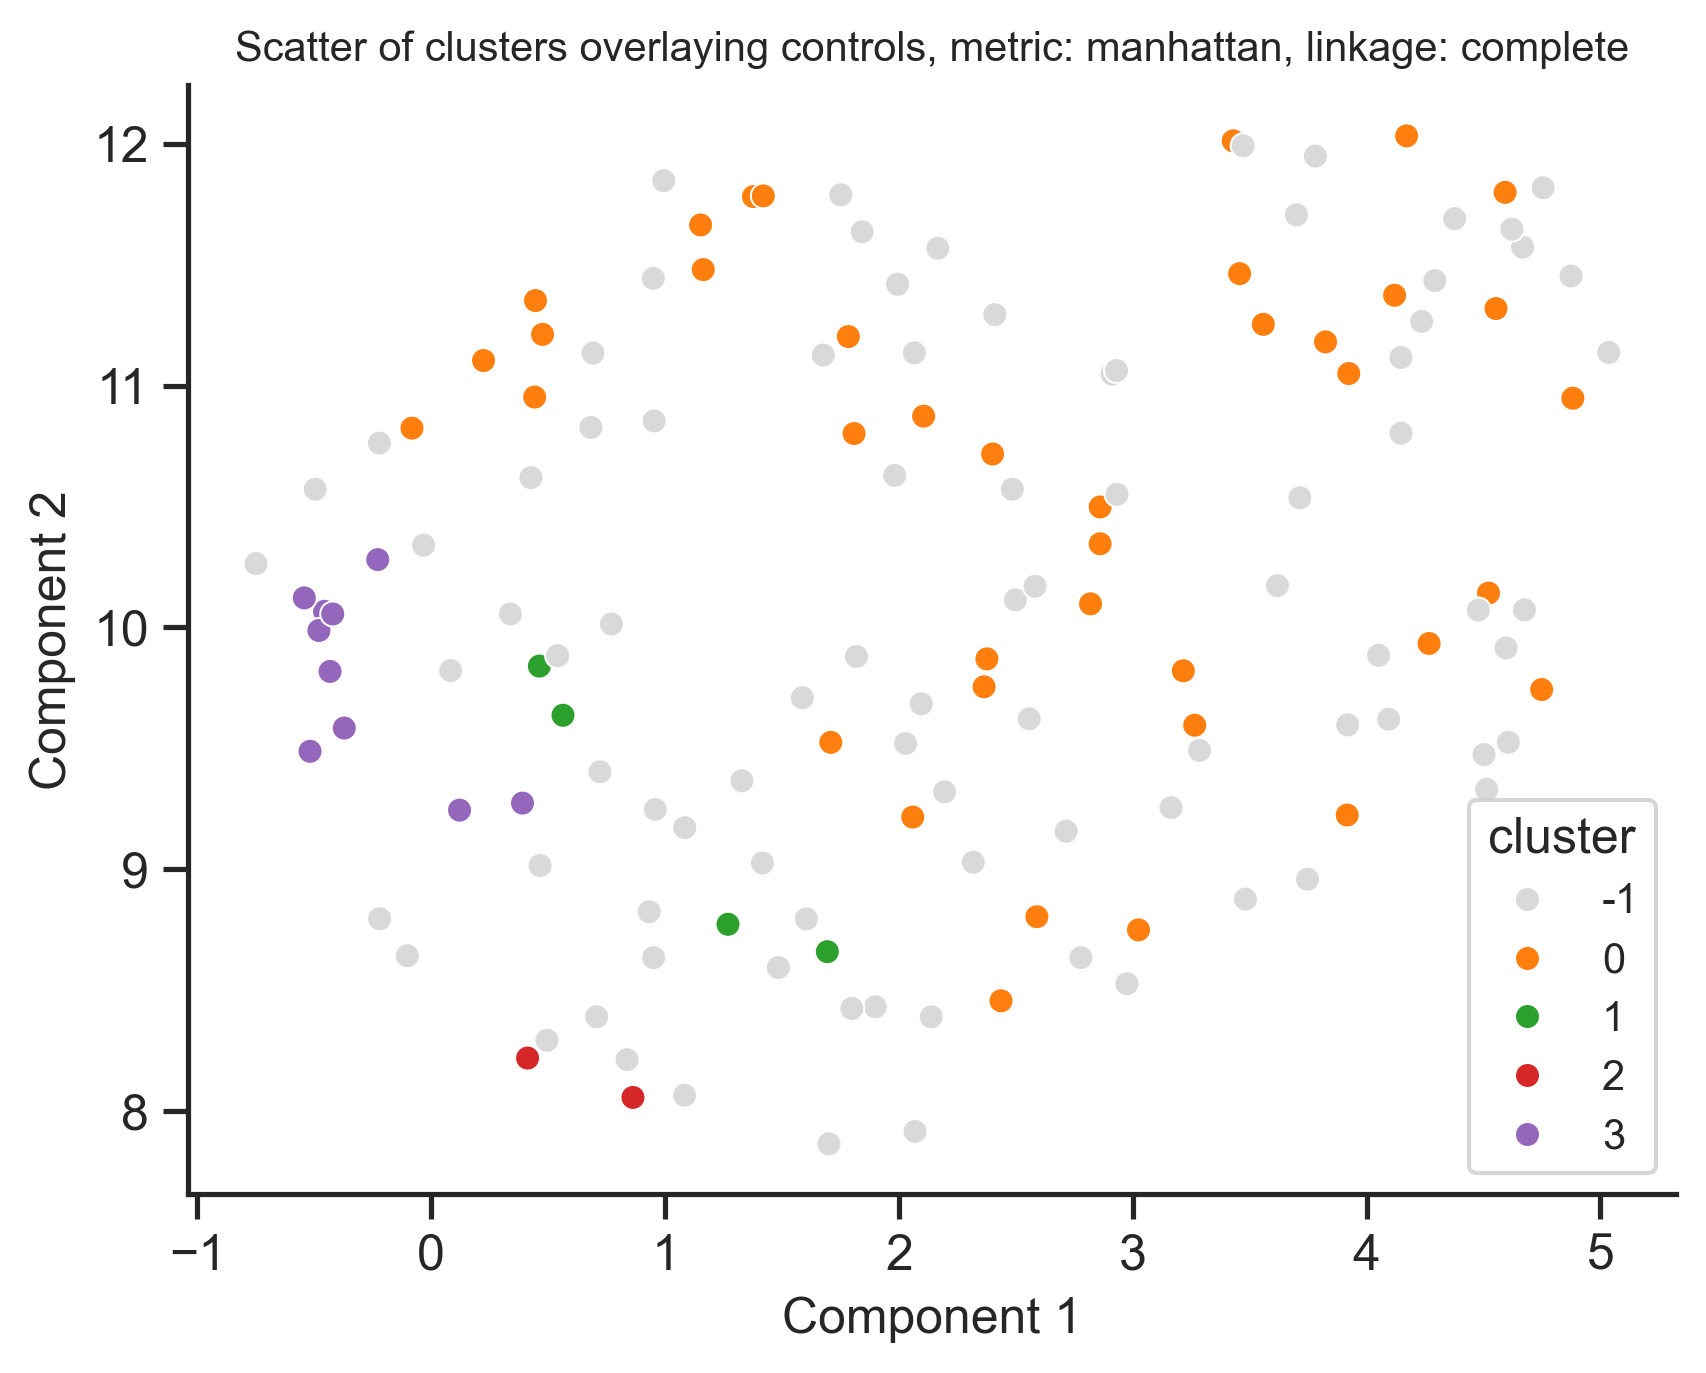

In [111]:

metric = 'manhattan'
linkage = 'complete'
agglomerative_model_args = {'n_clusters': None, 'linkage': linkage, 'metric': metric}

model = AgglomerativeClustering

clustering_results = perform_clustering(n_cluster=4, X=X_stdz, clustering_model=model, model_args=agglomerative_model_args.copy())
feature_importance_results = perform_feature_selection(X_train, X_test,clustering_results)
selected_features_results = perform_knee_locator(feature_importance_results)
plot_old_versus_new_clustering(X_stdz, selected_features_results, model, agglomerative_model_args.copy())
plt.savefig("/Users/viscom2025/Documents/images/agg_m_c_c4.png")

plot_scatter_of_clusters_with_controls(X_stdz
                                       , X_controls_stdz
                                       , selected_features_results
                                       , model 
                                       , model_args = agglomerative_model_args.copy()
                                       , title = "Scatter of clusters overlaying controls, metric: manhattan, linkage: complete")

plt.savefig("/Users/viscom2025/Documents/images/agg_m_c_c4-control_overlay.png")


  0%|          | 0/1 [00:00<?, ?it/s]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025-05-14 16:37:52,113 - INFO - 1141331686.perform_feature_selection:50 - Number of clusters: 5
2025-05-14 16:37:52,113 - INFO - 1141331686.perform_feature_selection:51 - Best model parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
2025-05-14 16:37:52,114 - INFO - 1141331686.perform_feature_selection:52 - Best score: 0.909
100%|██████████| 1/1 [00:02<00:00,  2.49s/it]
2025-05-14 16:37:52,117 - INFO - 1141331686.perform_knee_locator:99 - Knee detected at feature rank 10
2025-05-14 16:37:52,117 - INFO - 1141331686.perform_knee_locator:107 - Automatically selected 11 features
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site

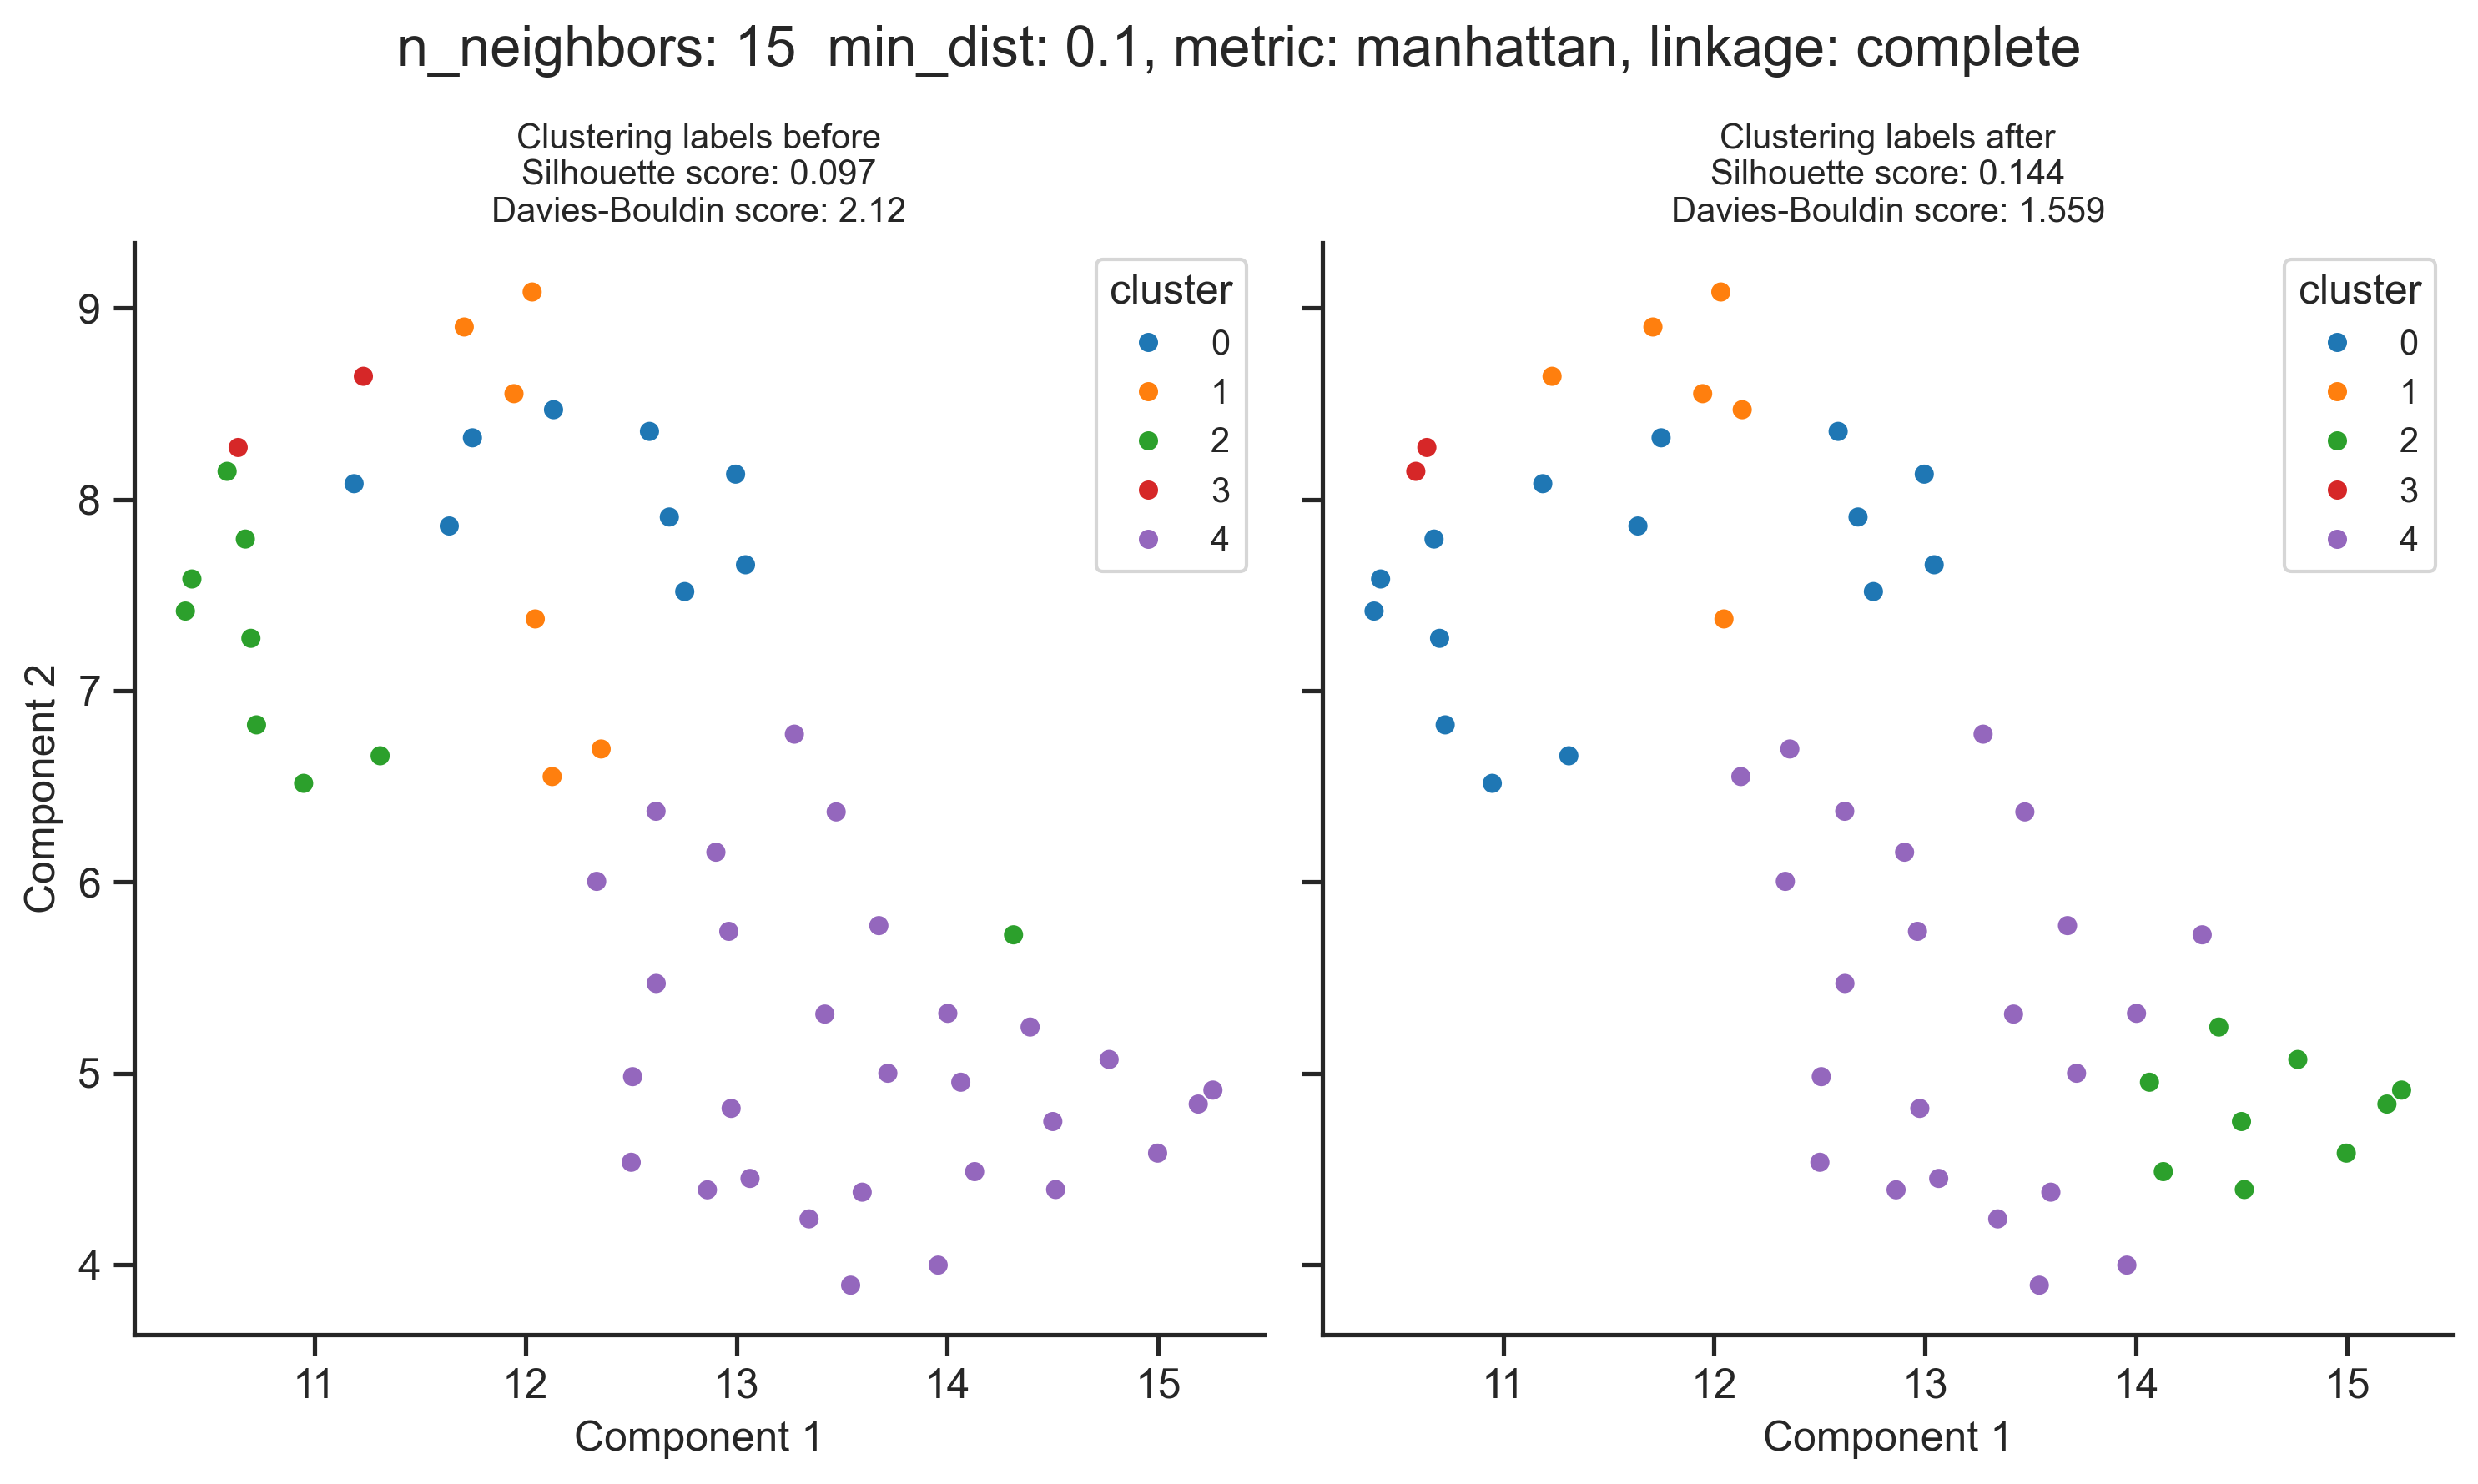

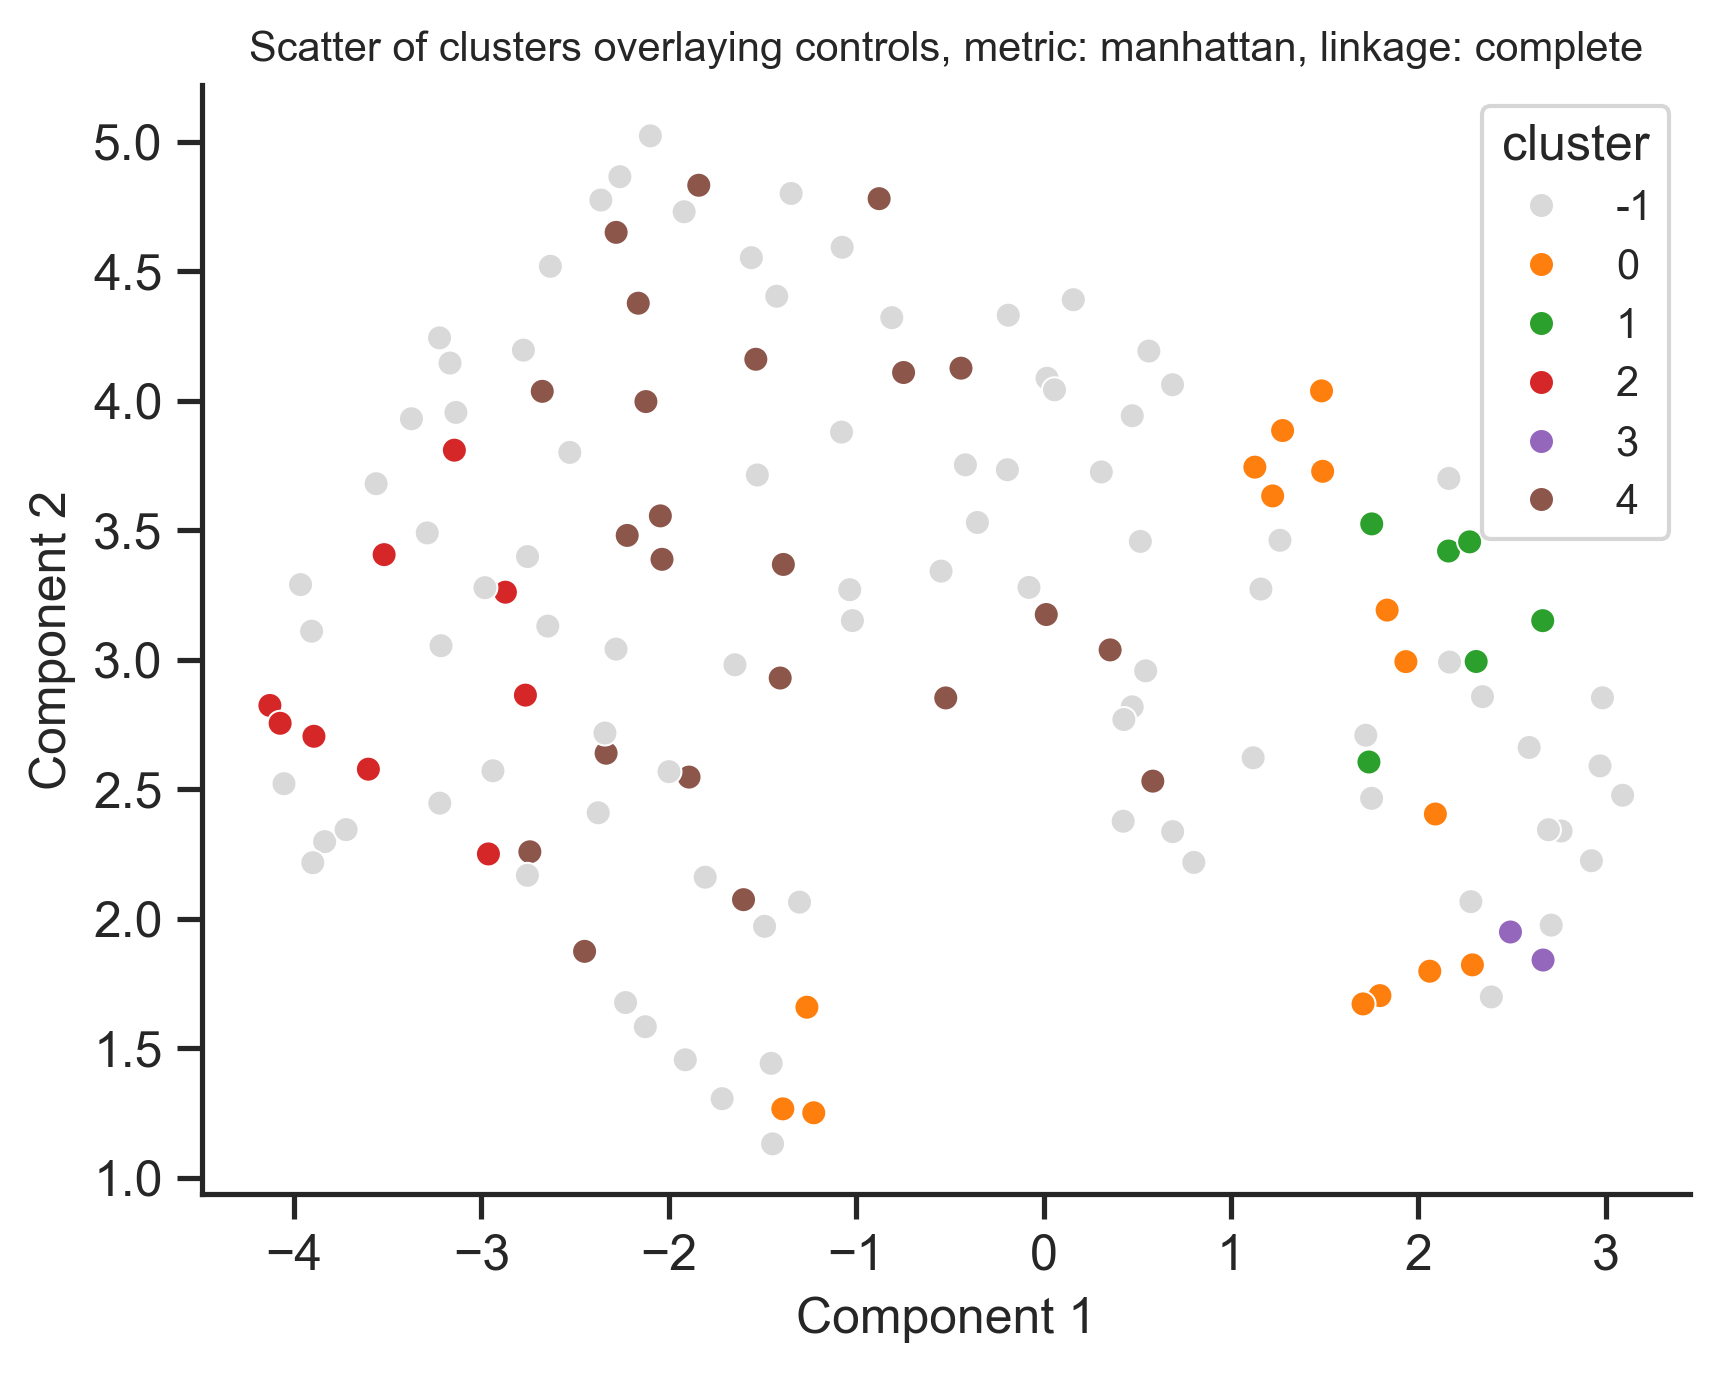

In [112]:

metric = 'manhattan'
linkage = 'complete'
agglomerative_model_args = {'n_clusters': None, 'linkage': linkage, 'metric': metric}

model = AgglomerativeClustering

clustering_results = perform_clustering(n_cluster=5, X=X_stdz, clustering_model=model, model_args=agglomerative_model_args.copy())
feature_importance_results = perform_feature_selection(X_train, X_test,clustering_results)
selected_features_results = perform_knee_locator(feature_importance_results)
plot_old_versus_new_clustering(X_stdz, selected_features_results, model, agglomerative_model_args.copy())
plt.savefig("/Users/viscom2025/Documents/images/agg_m_c_c5.png")


plot_scatter_of_clusters_with_controls(X_stdz
                                       , X_controls_stdz
                                       , selected_features_results
                                       , model 
                                       , model_args = agglomerative_model_args.copy()
                                       , title = "Scatter of clusters overlaying controls, metric: manhattan, linkage: complete")

plt.savefig("/Users/viscom2025/Documents/images/agg_m_c_c5-control_overlay.png")

  0%|          | 0/1 [00:00<?, ?it/s]

/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025-05-14 16:37:55,261 - INFO - 1141331686.perform_feature_selection:50 - Number of clusters: 6
2025-05-14 16:37:55,262 - INFO - 1141331686.perform_feature_selection:51 - Best model parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 30}
2025-05-14 16:37:55,262 - INFO - 1141331686.perform_feature_selection:52 - Best score: 0.727
100%|██████████| 1/1 [00:02<00:00,  2.30s/it]
2025-05-14 16:37:55,265 - INFO - 1141331686.perform_knee_locator:99 - Knee detected at feature rank 18
2025-05-14 16:37:55,265 - INFO - 1141331686.perform_knee_locator:107 - Automatically selected 19 features
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-

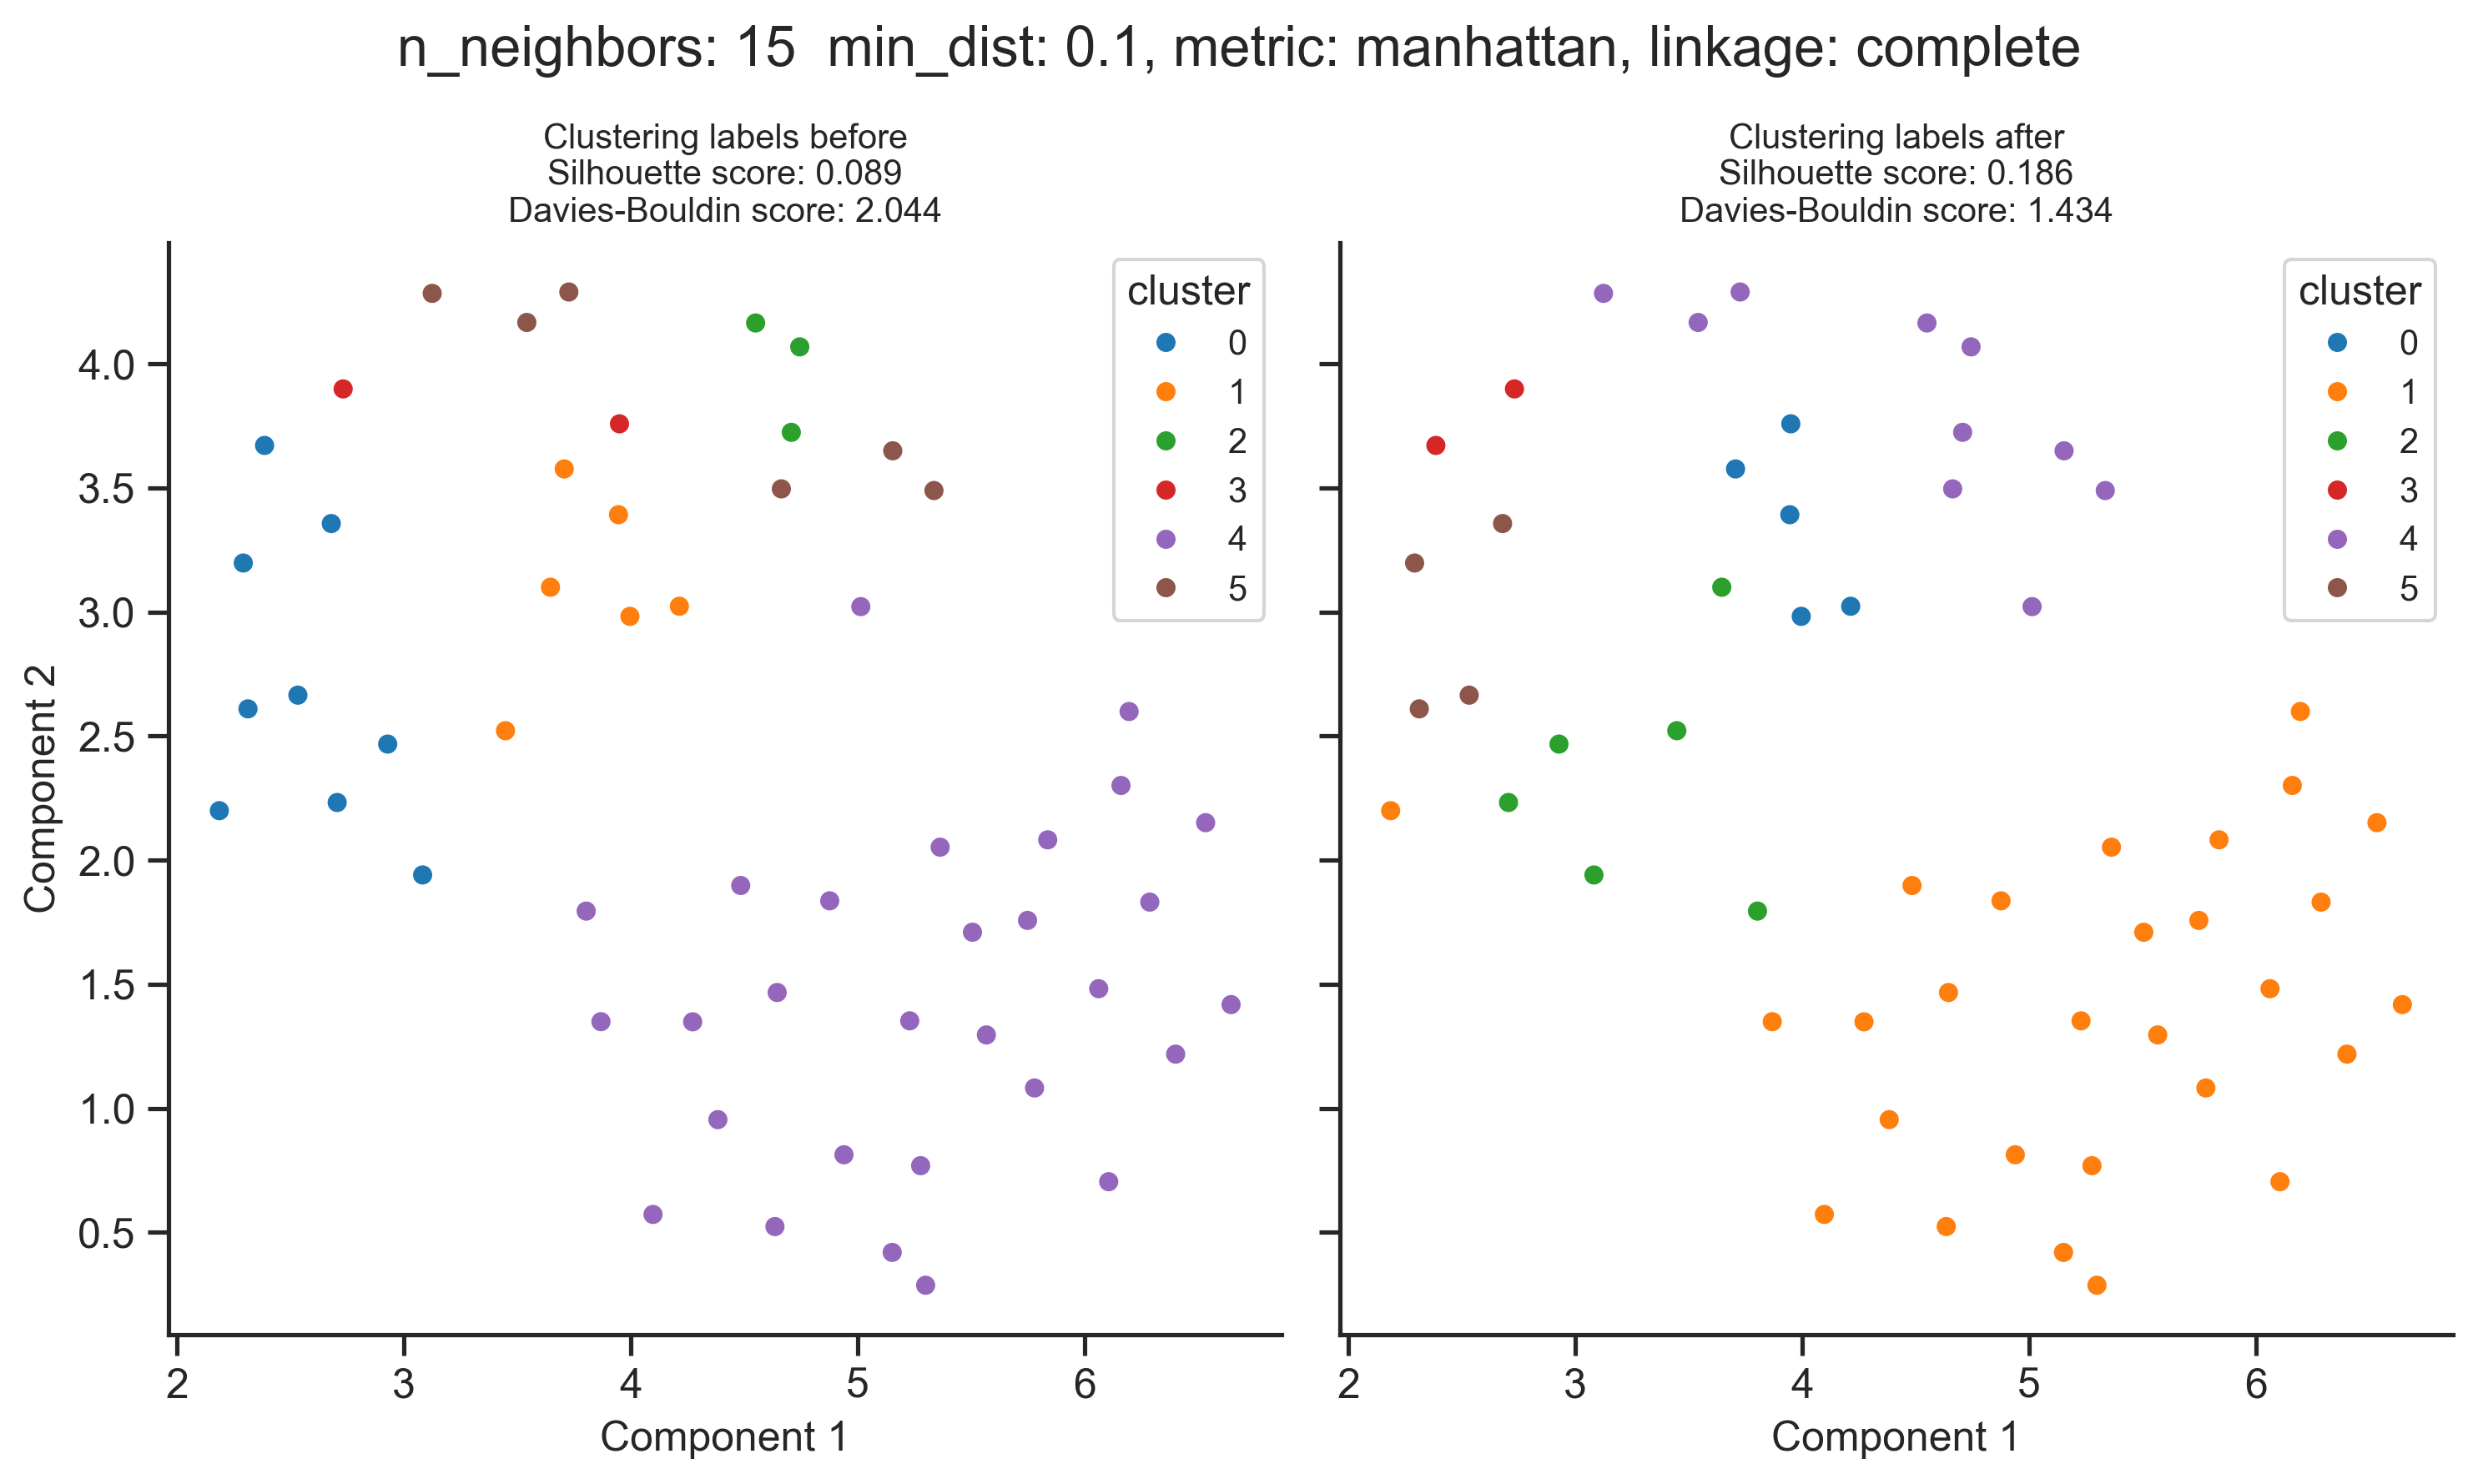

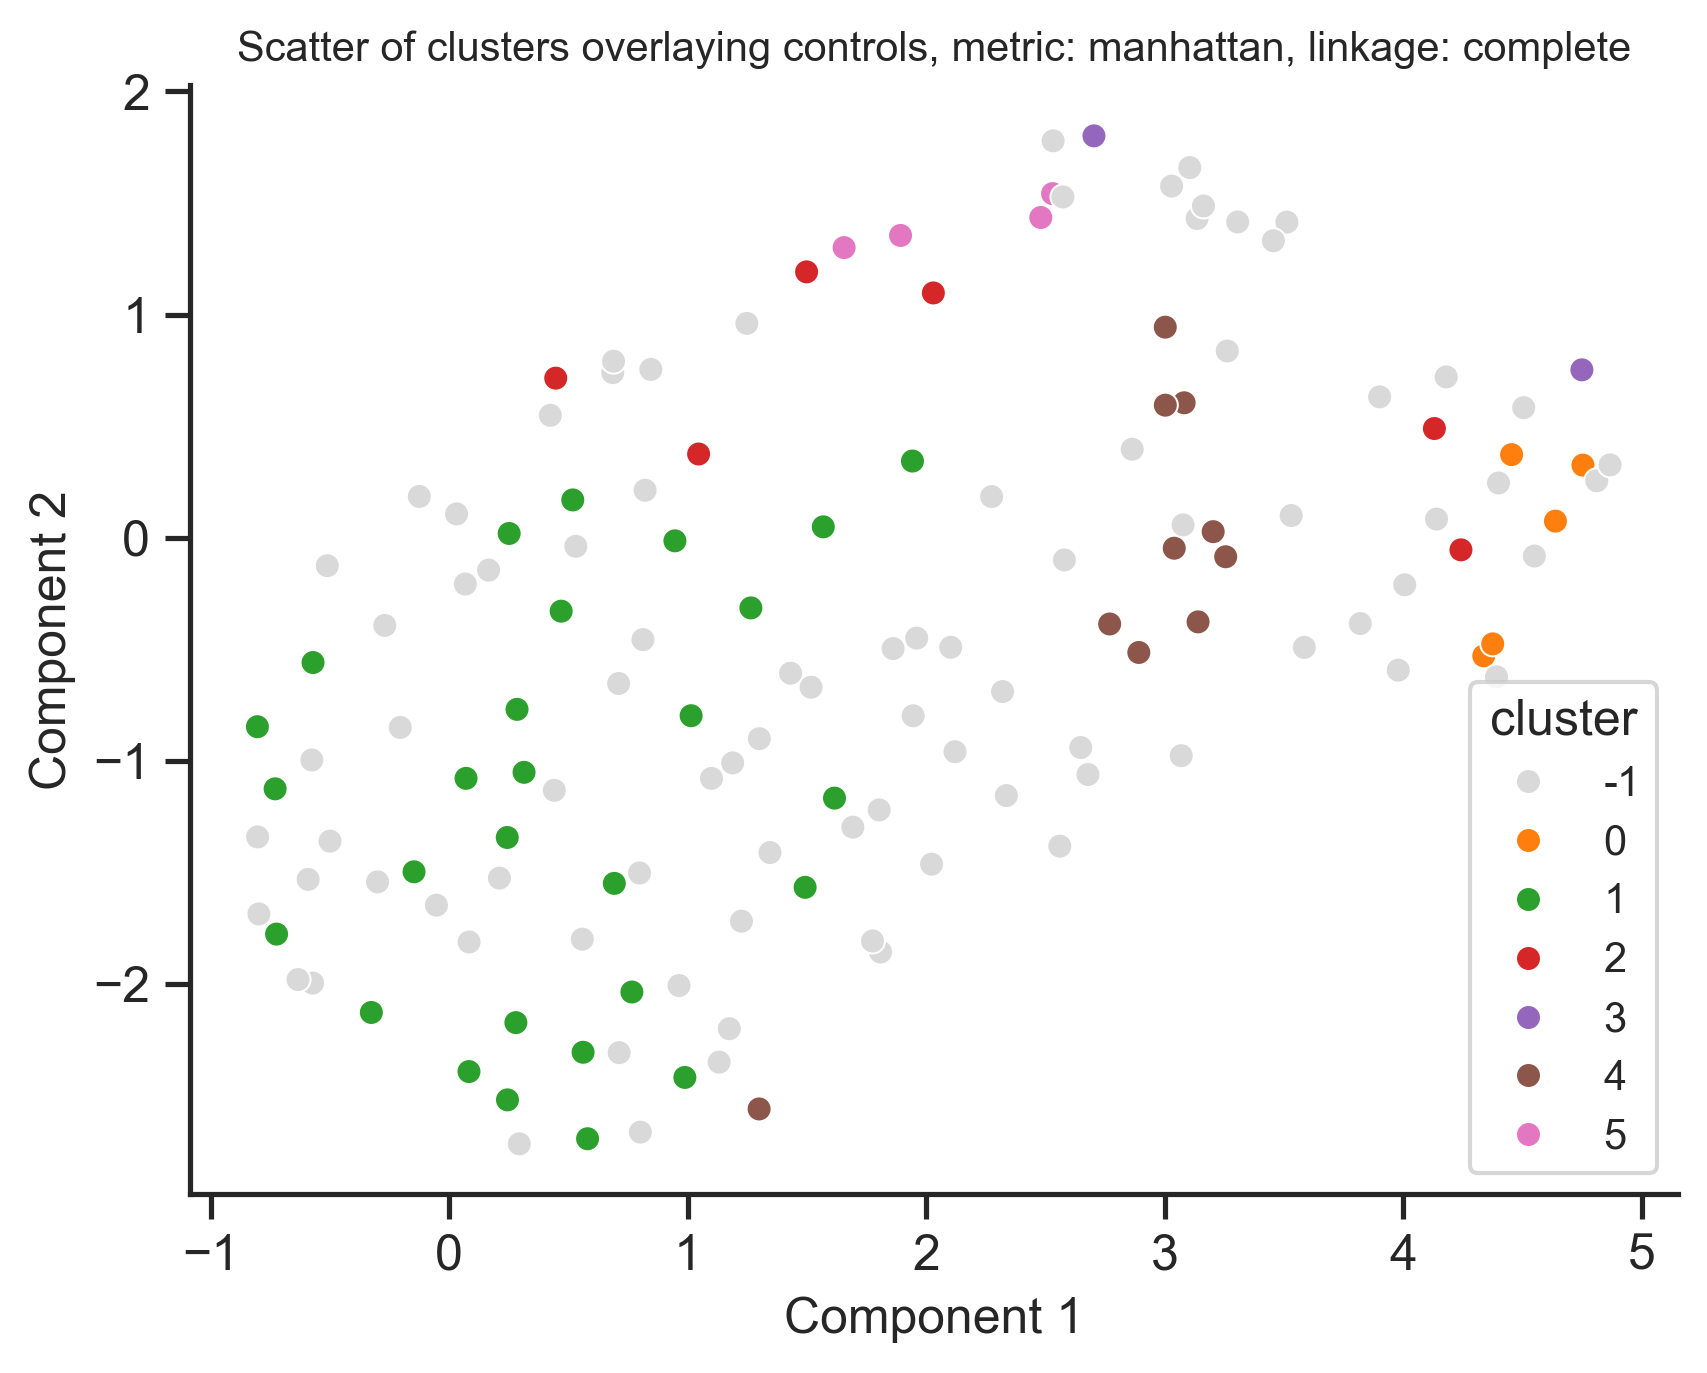

In [113]:

metric = 'manhattan'
linkage = 'complete'
agglomerative_model_args = {'n_clusters': None, 'linkage': linkage, 'metric': metric}

model = AgglomerativeClustering

clustering_results = perform_clustering(n_cluster=6, X=X_stdz, clustering_model=model, model_args=agglomerative_model_args.copy())
feature_importance_results = perform_feature_selection(X_train, X_test, clustering_results)
selected_features_results = perform_knee_locator(feature_importance_results)
plot_old_versus_new_clustering(X_stdz, selected_features_results, model, agglomerative_model_args.copy())

plt.savefig("/Users/viscom2025/Documents/images/agg_m_c_c6.png")

plot_scatter_of_clusters_with_controls(X_stdz
                                       , X_controls_stdz
                                       , selected_features_results
                                       , model 
                                       , model_args = agglomerative_model_args.copy()
                                       , title = "Scatter of clusters overlaying controls, metric: manhattan, linkage: complete")

plt.savefig("/Users/viscom2025/Documents/images/agg_m_c_c6-control_overlay.png")

# Gaussian Mixtures results

In [114]:
feature_importance_results = perform_feature_selection(X_train, X_test, gmm_range_df)
selected_features_results = perform_knee_locator(feature_importance_results)

selected_features = (pd.concat(selected_features_results["selected_features"])
.groupby("index")
.size()
.reset_index(name="n_appearences")
.sort_values("n_appearences", ascending=False)
)

gmm_selected_features = selected_features

print_latex(selected_features)


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025-05-14 16:37:58,269 - INFO - 1141331686.perform_feature_selection:50 - Number of clusters: 2
2025-05-14 16:37:58,270 - INFO - 1141331686.perform_feature_selection:51 - Best model parameters: {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 30}
2025-05-14 16:37:58,270 - INFO - 1141331686.perform_feature_selection:52 - Best score: 0.818
100%|██████████| 1/1 [00:02<00:00,  2.18s/it]
2025-05-14 16:37:58,273 - INFO - 1141331686.perform_knee_locator:99 - Knee detected at feature rank 10
2025-05-14 16:37:58,273 - INFO - 1141331686.perform_knee_locator:107 - Automatically selected 11 features


EVIL_BASTARD_duration_std_fix & 1
EVIL_BASTARD_x_fixation_dist_min & 1
FITTS_LAW_y_acceleration_mean & 1
KING_DEVICK_peak_velocity_max_sacc & 1
KING_DEVICK_peak_velocity_std_sacc & 1
KING_DEVICK_total_acceleration_magnitude_mean & 1
KING_DEVICK_total_acceleration_magnitude_median & 1
REACTION_total_acceleration_magnitude_median & 1
SHAPES_total_acceleration_magnitude_mean & 1
SMOOTH_PURSUITS_amplitude_max_sacc & 1
SMOOTH_PURSUITS_amplitude_std_sacc & 1


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 60 candidates, totalling 300 fits


2025-05-14 16:38:02,272 - INFO - 1141331686.perform_feature_selection:50 - Number of clusters: 2
2025-05-14 16:38:02,273 - INFO - 1141331686.perform_feature_selection:51 - Best model parameters: {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 30}
2025-05-14 16:38:02,273 - INFO - 1141331686.perform_feature_selection:52 - Best score: 0.818
100%|██████████| 1/1 [00:02<00:00,  2.24s/it]
2025-05-14 16:38:02,276 - INFO - 1141331686.perform_knee_locator:99 - Knee detected at feature rank 10
2025-05-14 16:38:02,277 - INFO - 1141331686.perform_knee_locator:107 - Automatically selected 11 features
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-

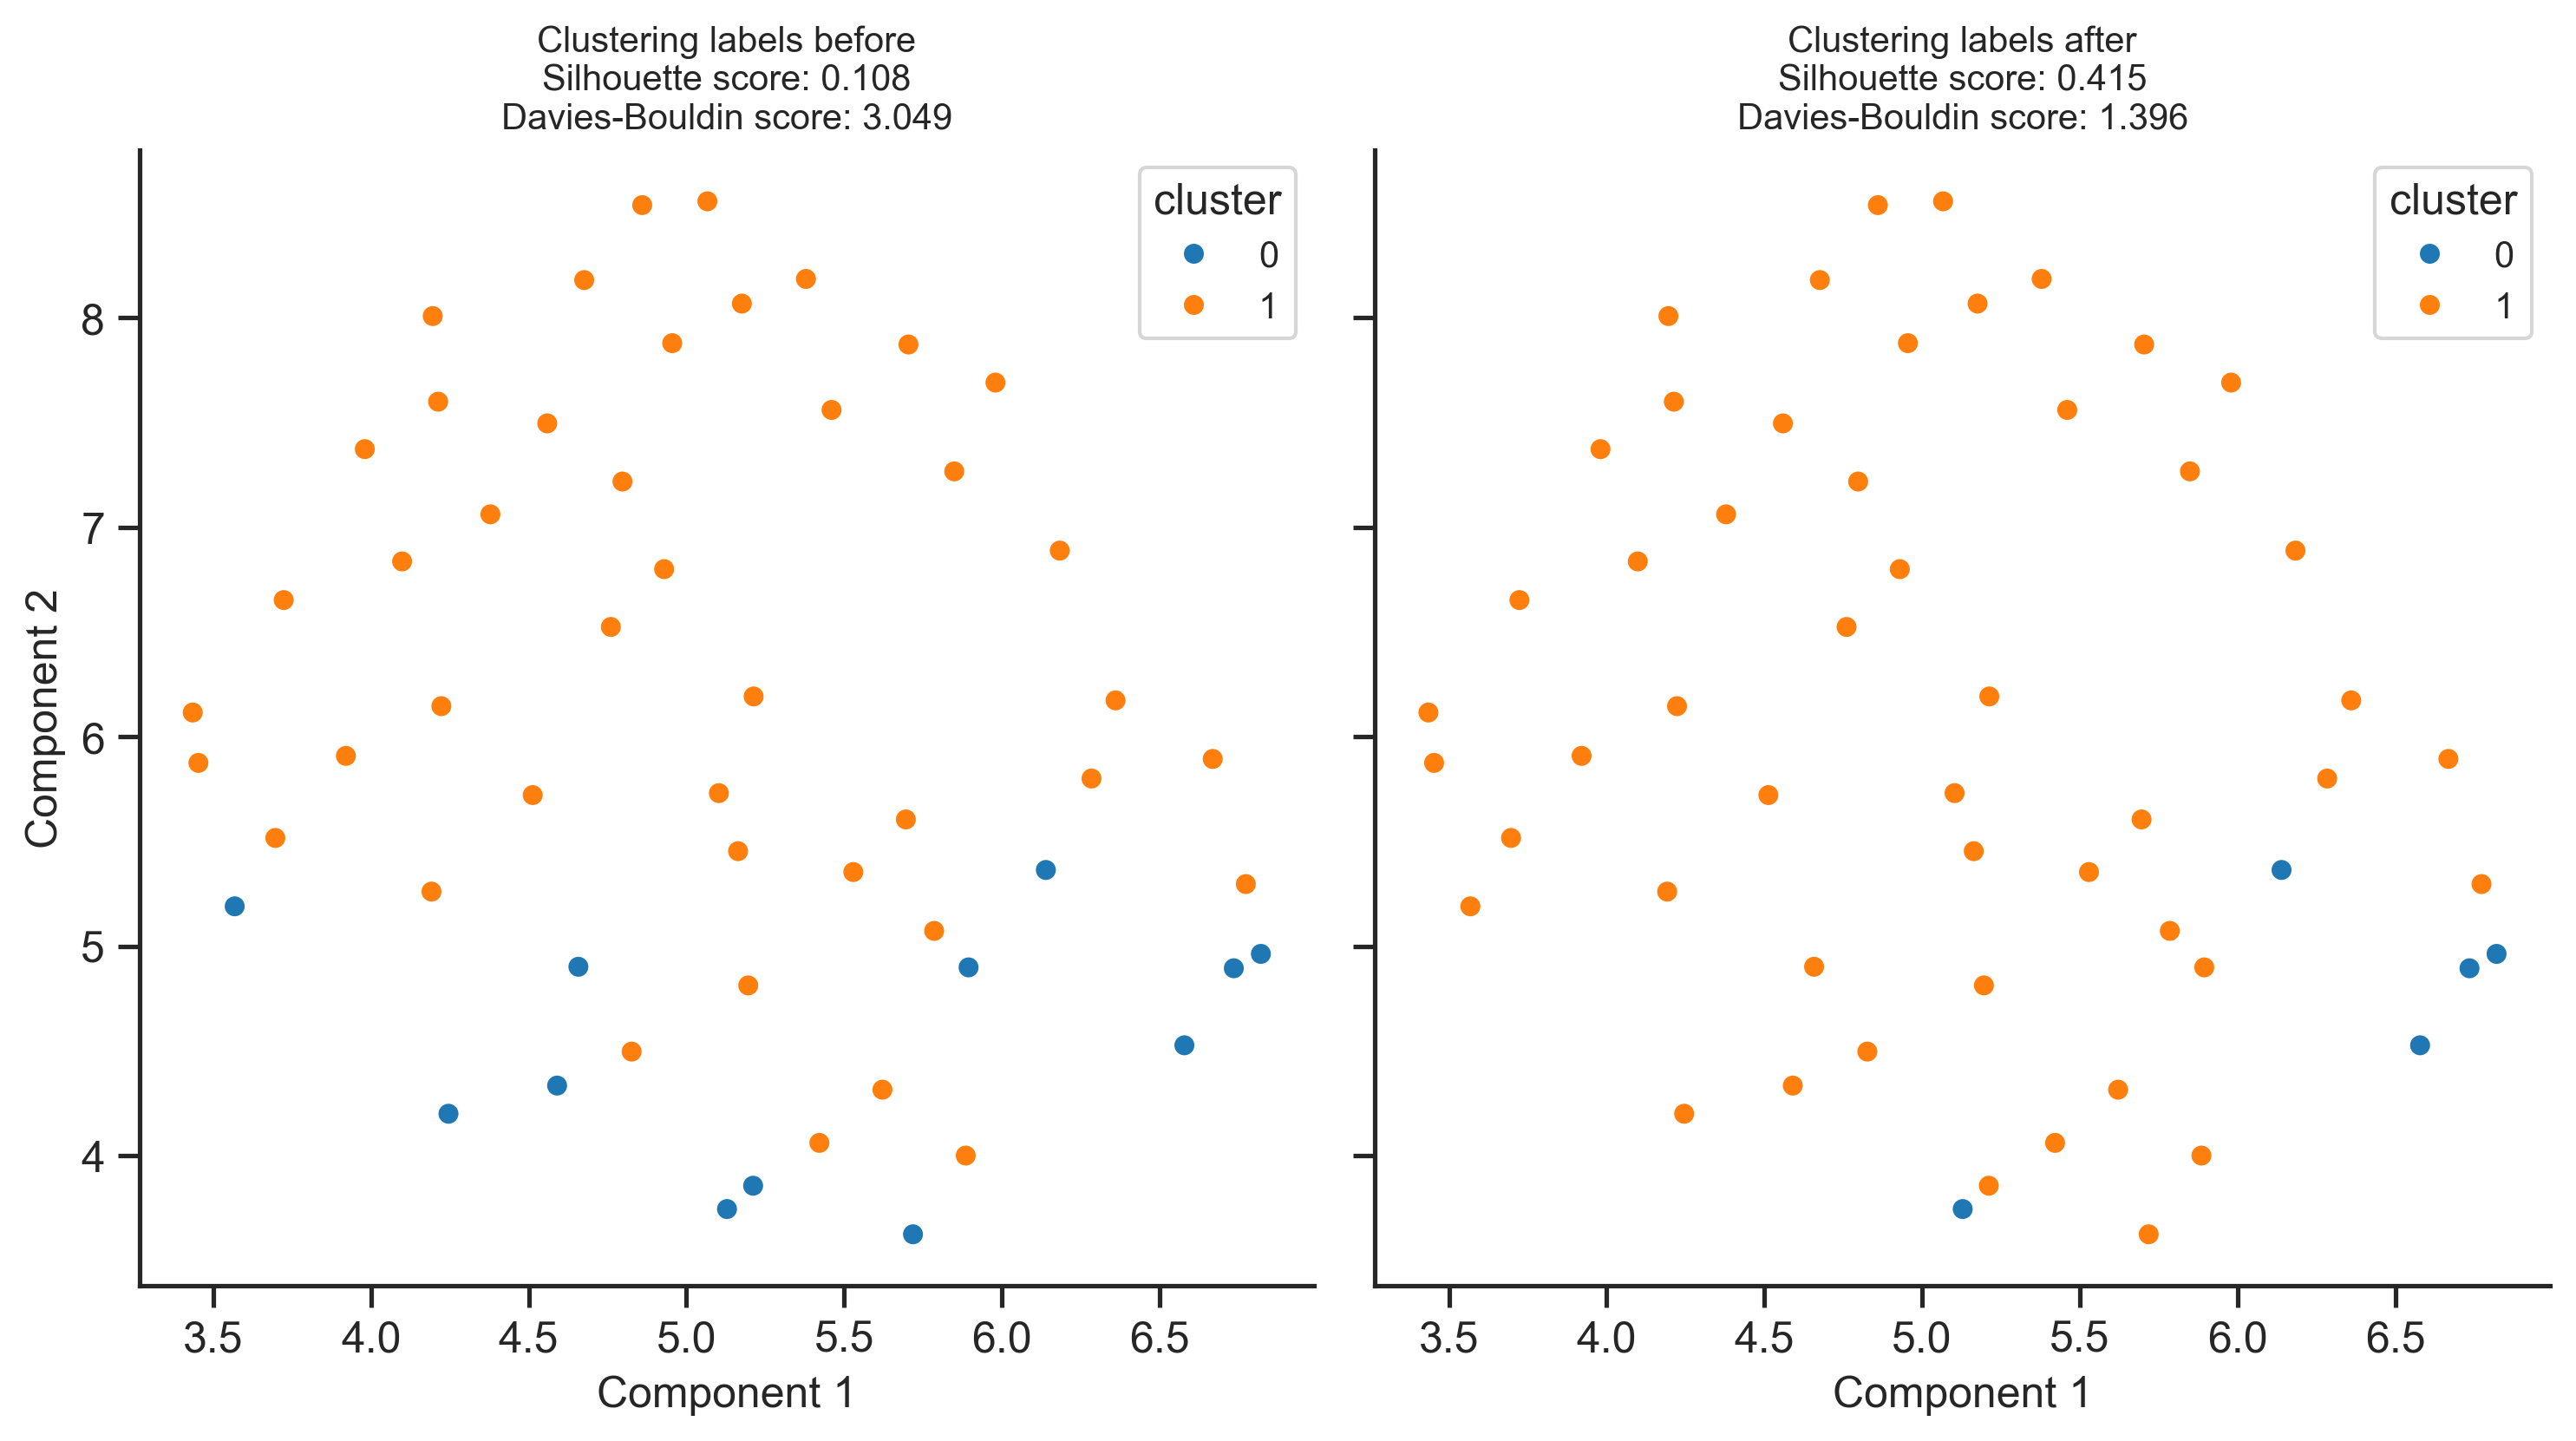

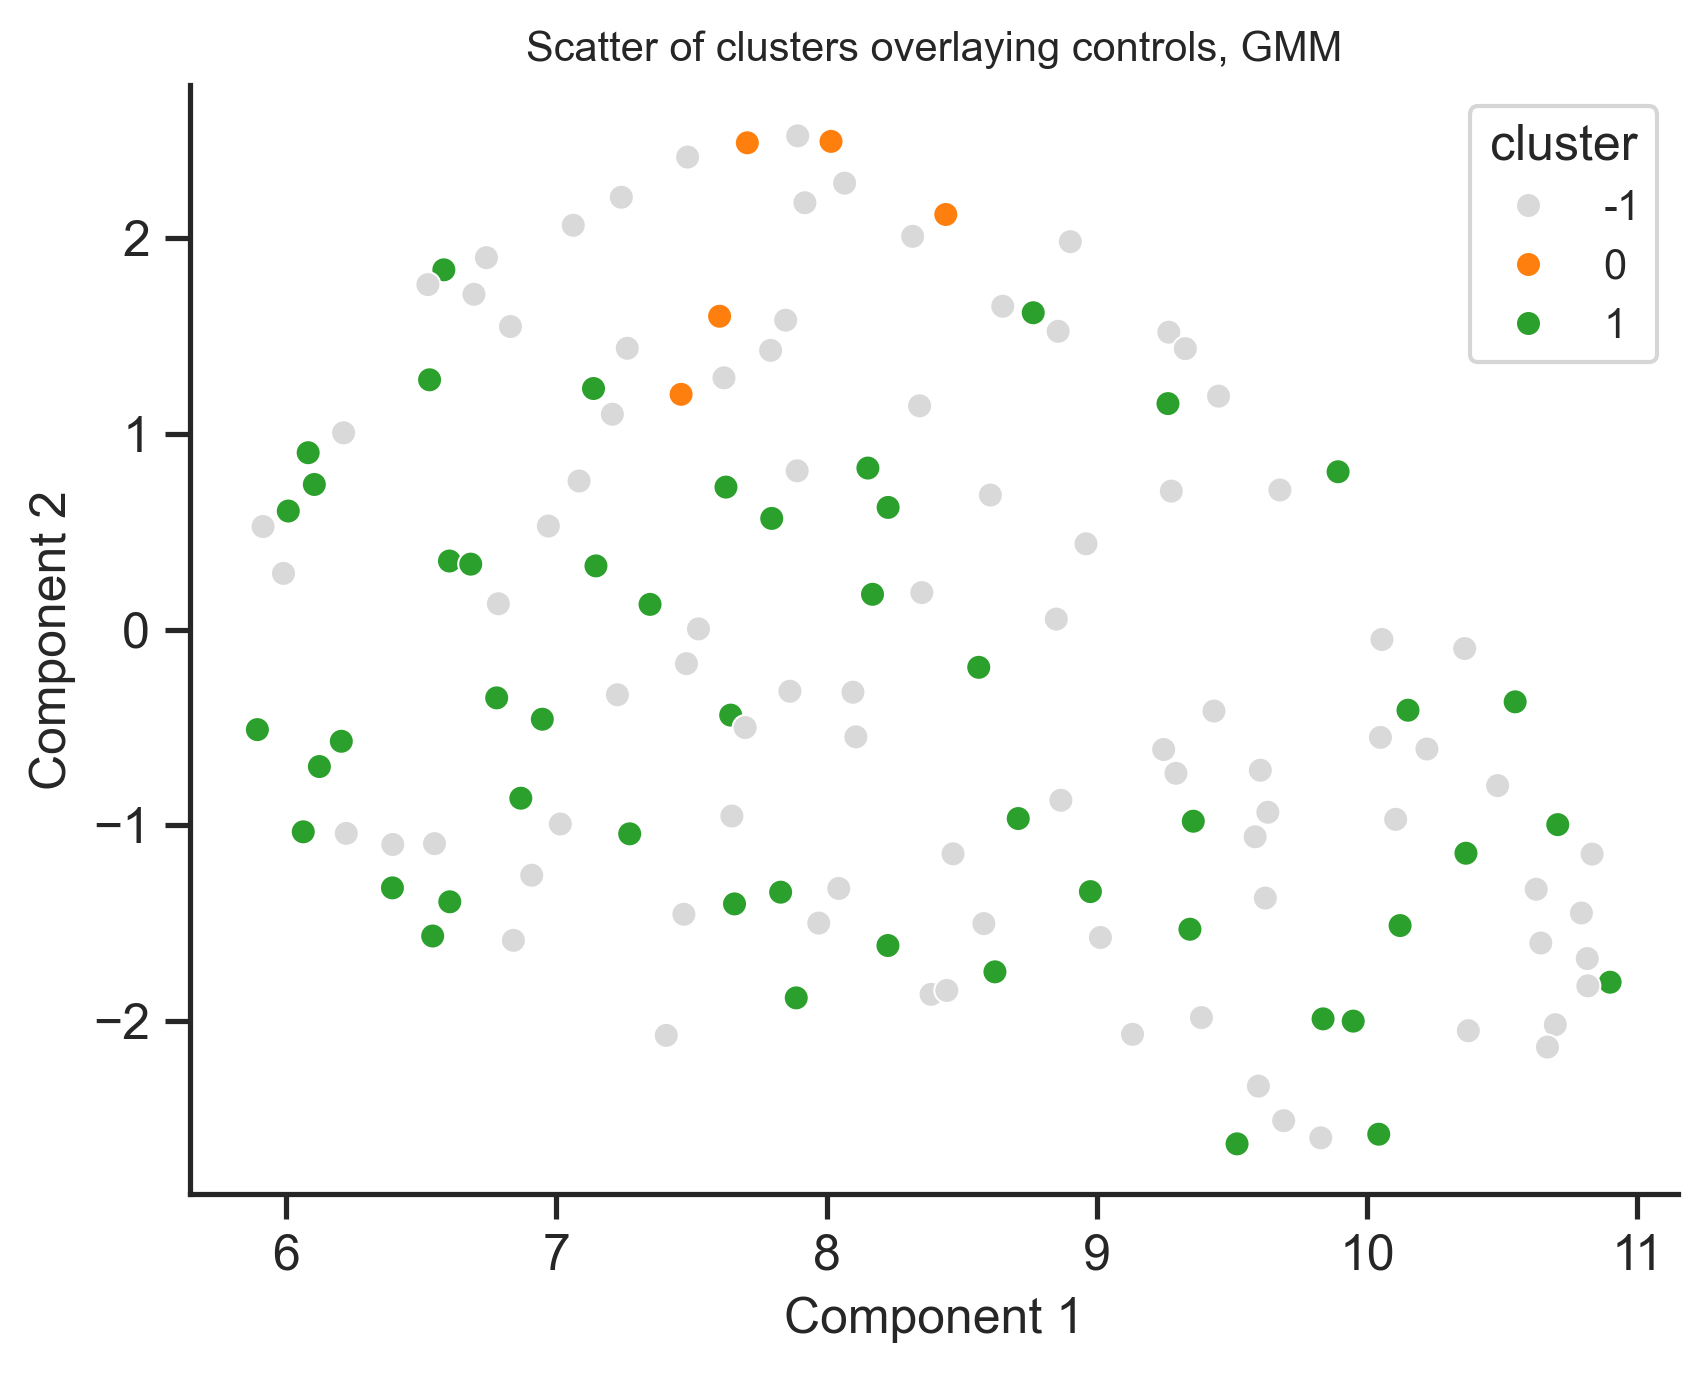

In [115]:

model = GaussianMixture

clustering_results = perform_clustering(n_cluster=2, X=X_stdz, clustering_model=model, model_args=gaussian_mixture_model_args.copy())
feature_importance_results = perform_feature_selection(X_train, X_test,clustering_results)
selected_features_results = perform_knee_locator(feature_importance_results)
plot_old_versus_new_clustering(X_stdz, selected_features_results, model, gaussian_mixture_model_args.copy())
plt.suptitle("")

plt.savefig("/Users/viscom2025/Documents/images/gmm_c2.png")

plot_scatter_of_clusters_with_controls(X_stdz
                                       , X_controls_stdz
                                       , selected_features_results
                                       , model 
                                       , model_args = gaussian_mixture_model_args.copy()
                                       , title = "Scatter of clusters overlaying controls, GMM")

plt.savefig("/Users/viscom2025/Documents/images/gmm_c2-control_overlay.png")

# Combine

In [116]:


selected_features_combined = (pd.concat([agg_e_w_selected_features, agg_m_c_selected_features, gmm_selected_features])
.groupby("index")
.agg({'n_appearences': sum})
.reset_index()
.sort_values("n_appearences", ascending=False)
)

print_latex(selected_features_combined)


SMOOTH_PURSUITS_total_acceleration_magnitude_mean & 5
FIXATIONS_duration_std_fix & 4
FITTS_LAW_duration_std_fix & 4
REACTION_duration_median_fix & 3
EVIL_BASTARD_total_acceleration_magnitude_mean & 3
FIXATIONS_x_acceleration_std & 3
ANTI_SACCADE_amplitude_mean_sacc & 2
SMOOTH_PURSUITS_y_acceleration_mean & 2
SHAPES_y_acceleration_std & 2
SHAPES_x_acceleration_std & 2
SHAPES_total_acceleration_magnitude_mean & 2
REACTION_total_acceleration_magnitude_median & 2
KING_DEVICK_x_acceleration_std & 2
KING_DEVICK_total_acceleration_magnitude_median & 2
KING_DEVICK_total_acceleration_magnitude_mean & 2
ANTI_SACCADE_reaction_time_std & 2
FITTS_LAW_amplitude_median_sacc & 2
FITTS_LAW_x_acceleration_max & 1
REACTION_prop_correct_trials & 1
ANTI_SACCADE_duration_median_fix & 1
SMOOTH_PURSUITS_distance_to_fixpoint_x_max & 1
SMOOTH_PURSUITS_amplitude_std_sacc & 1
SMOOTH_PURSUITS_amplitude_max_sacc & 1
SHAPES_y_fixation_dist_mean & 1
ANTI_SACCADE_saccades_per_second_median & 1
ANTI_SACCADE_y_accelerat

/var/folders/v0/l_dtghc15651j6_9p3clc_r00000gt/T/ipykernel_75686/3050122859.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({'n_appearences': sum})
